# importing libs and data

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('all.csv')

def b365_odds_to_probability(odds):
    
    probability = 1 / odds
    return probability


# Data Transformation

In [154]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data['Season'] = np.where(
    data['Date'].dt.month >= 8,
    data['Date'].dt.year.astype(str) + "/" + (data['Date'].dt.year + 1).astype(str),
    (data['Date'].dt.year - 1).astype(str) + "/" + data['Date'].dt.year.astype(str)
)
data['Season'] = data['Season'].astype('category')
data.drop(['Date'], axis=1, inplace=True)
print('before deleting nan and zeros: ', data.shape)
data.dropna()
data = data[data['B365H'] != 0]
data = data[data['B365D'] != 0]
data = data[data['B365A'] != 0]
print('after deleting nan and zeros: ', data.shape)

before deleting nan and zeros:  (4006, 27)
after deleting nan and zeros:  (4006, 27)


# calculating data for referees per season

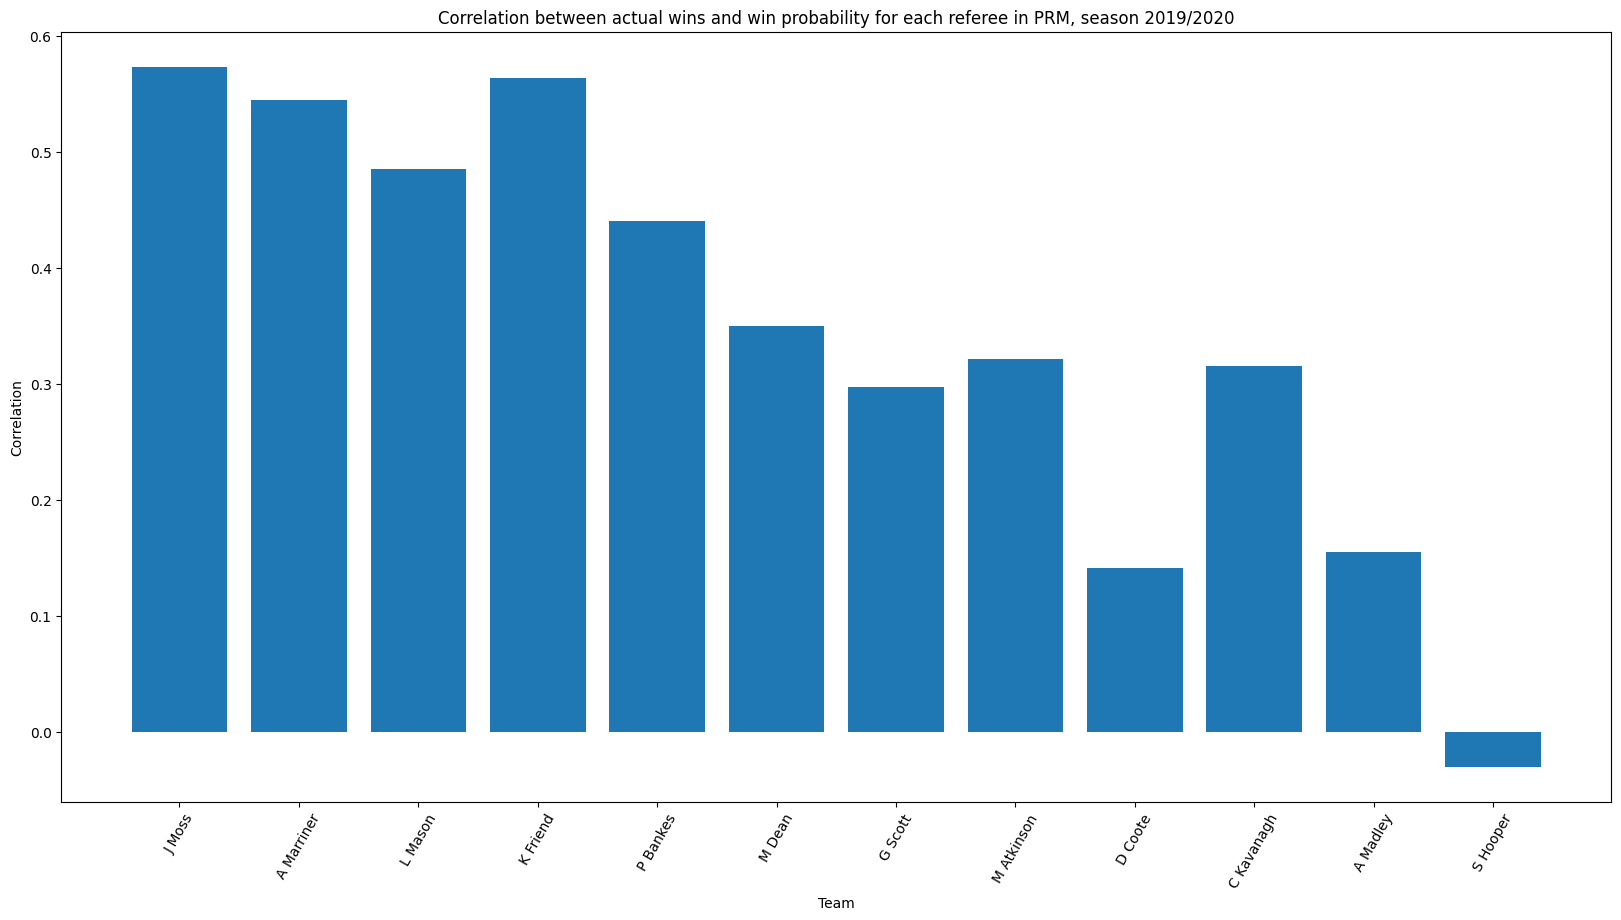

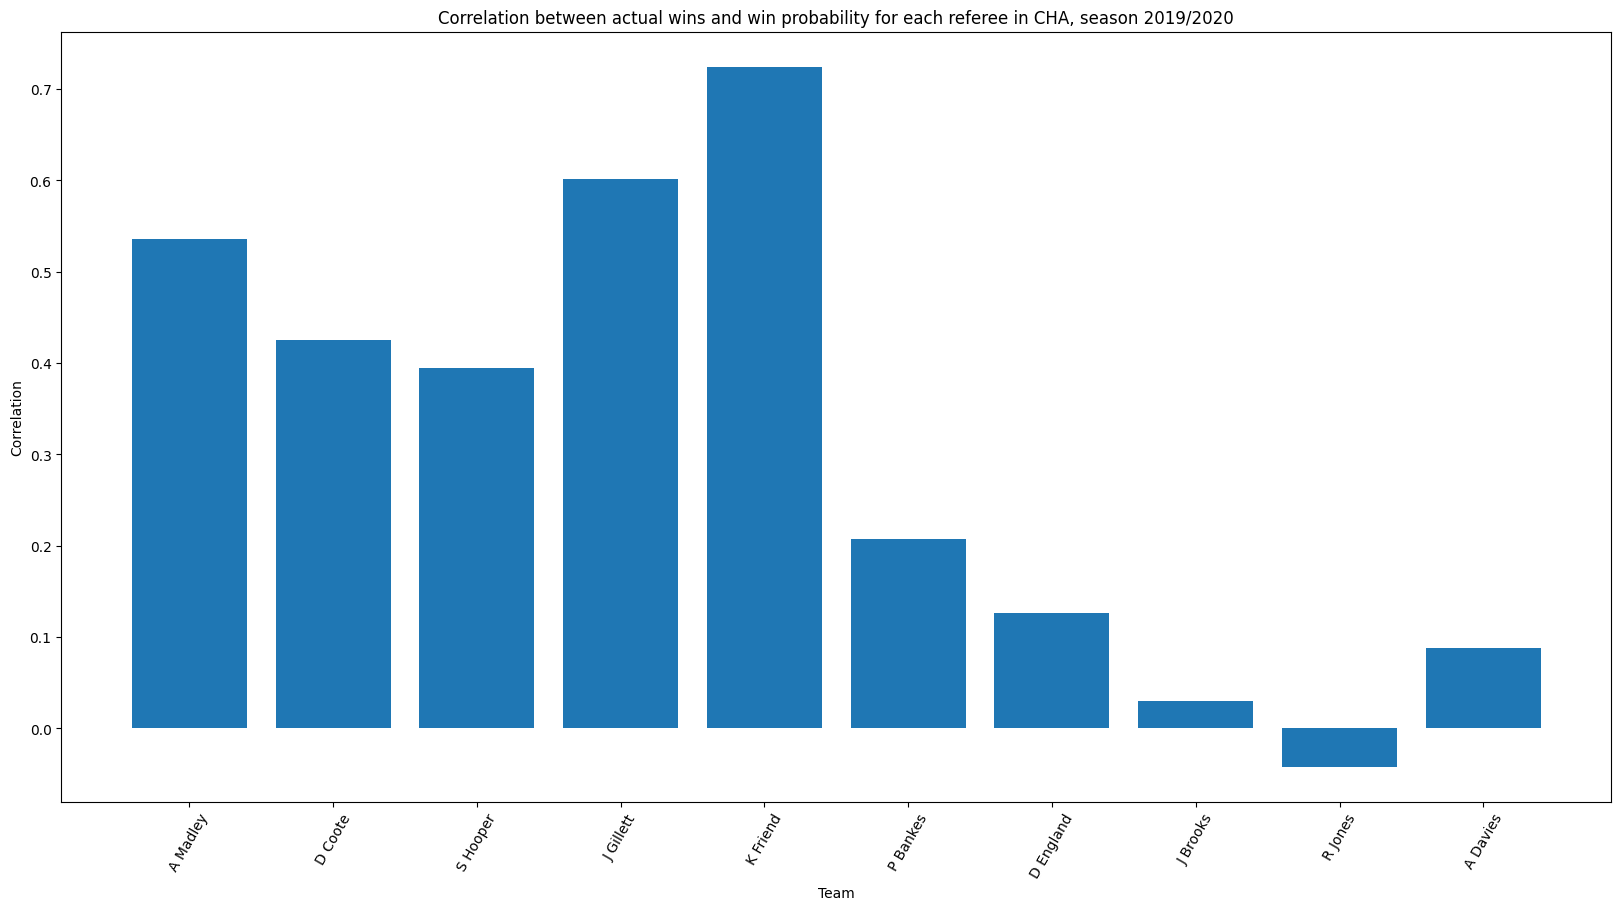

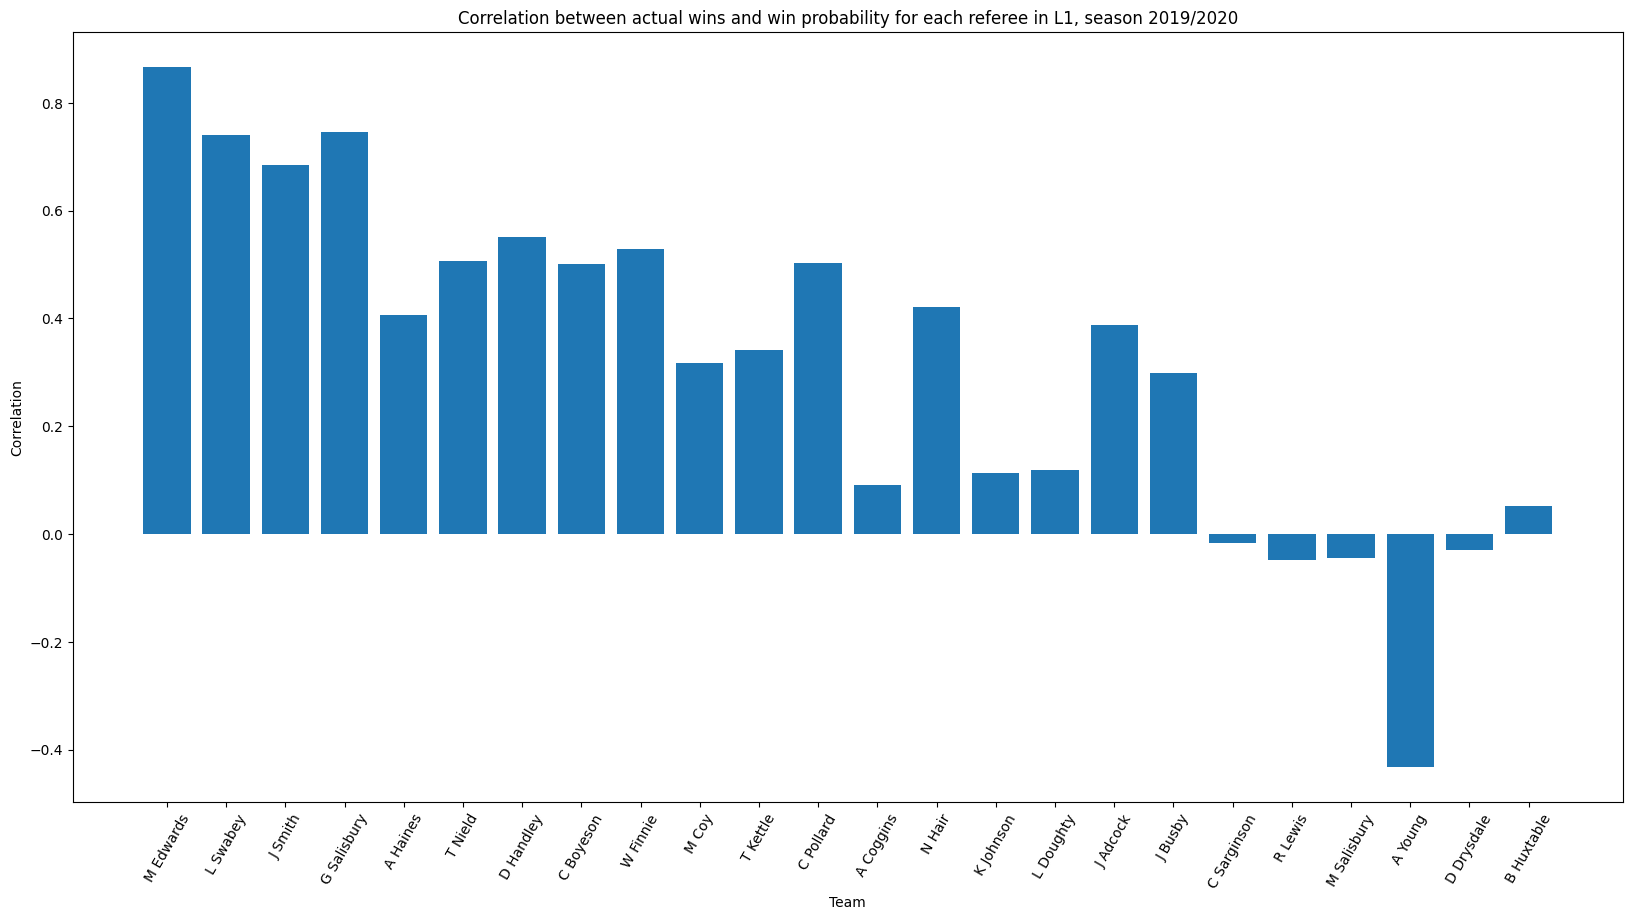

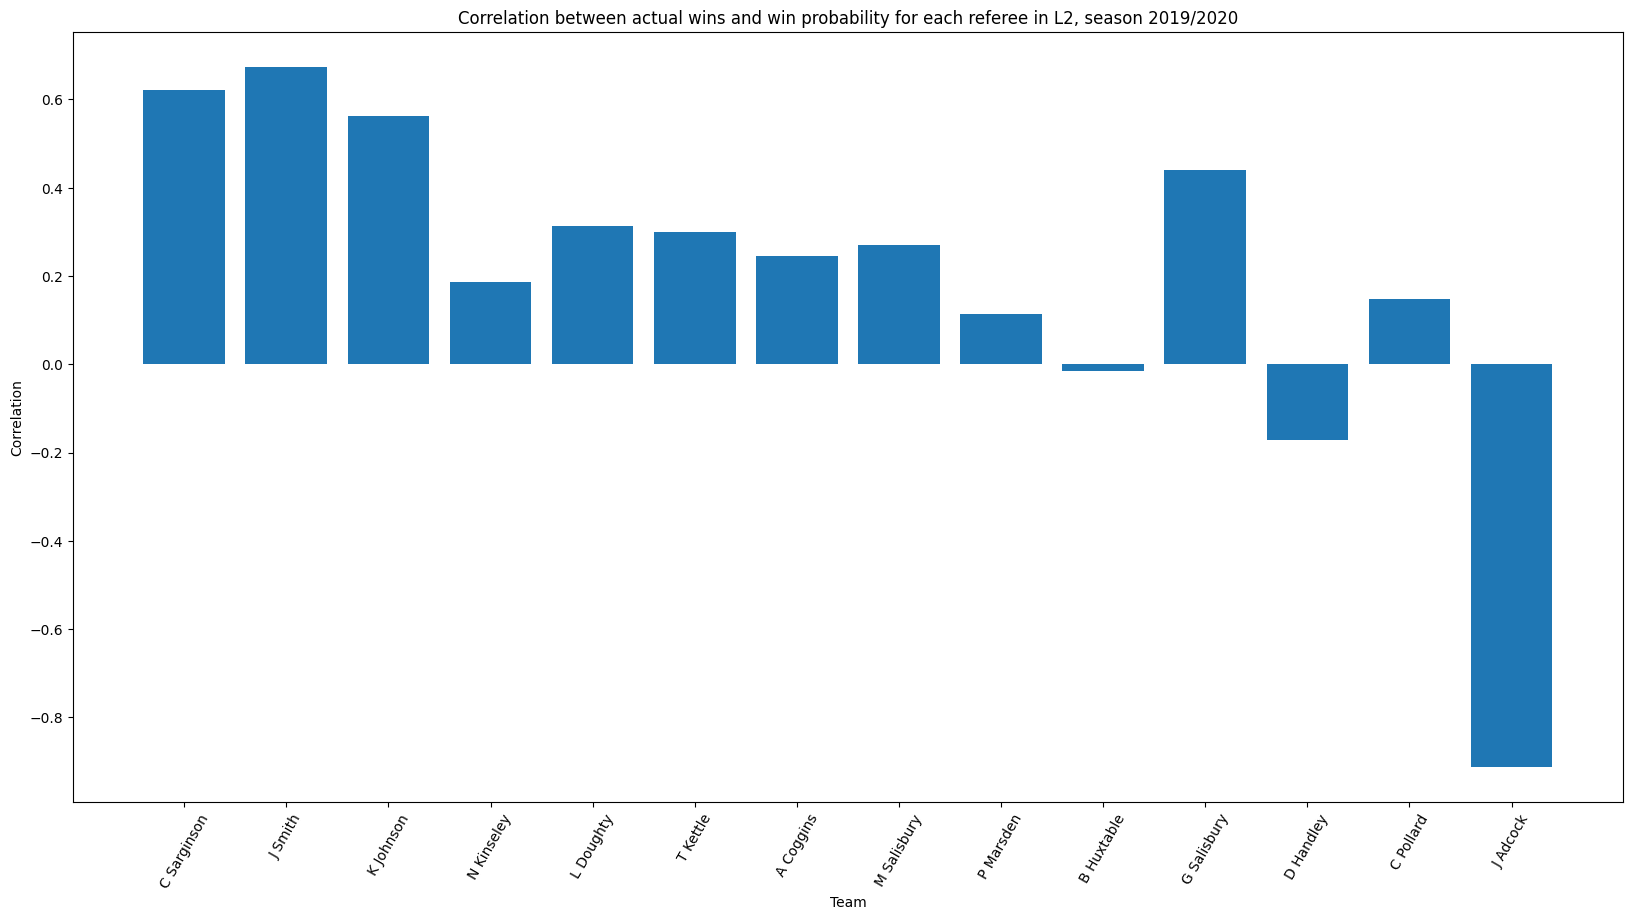

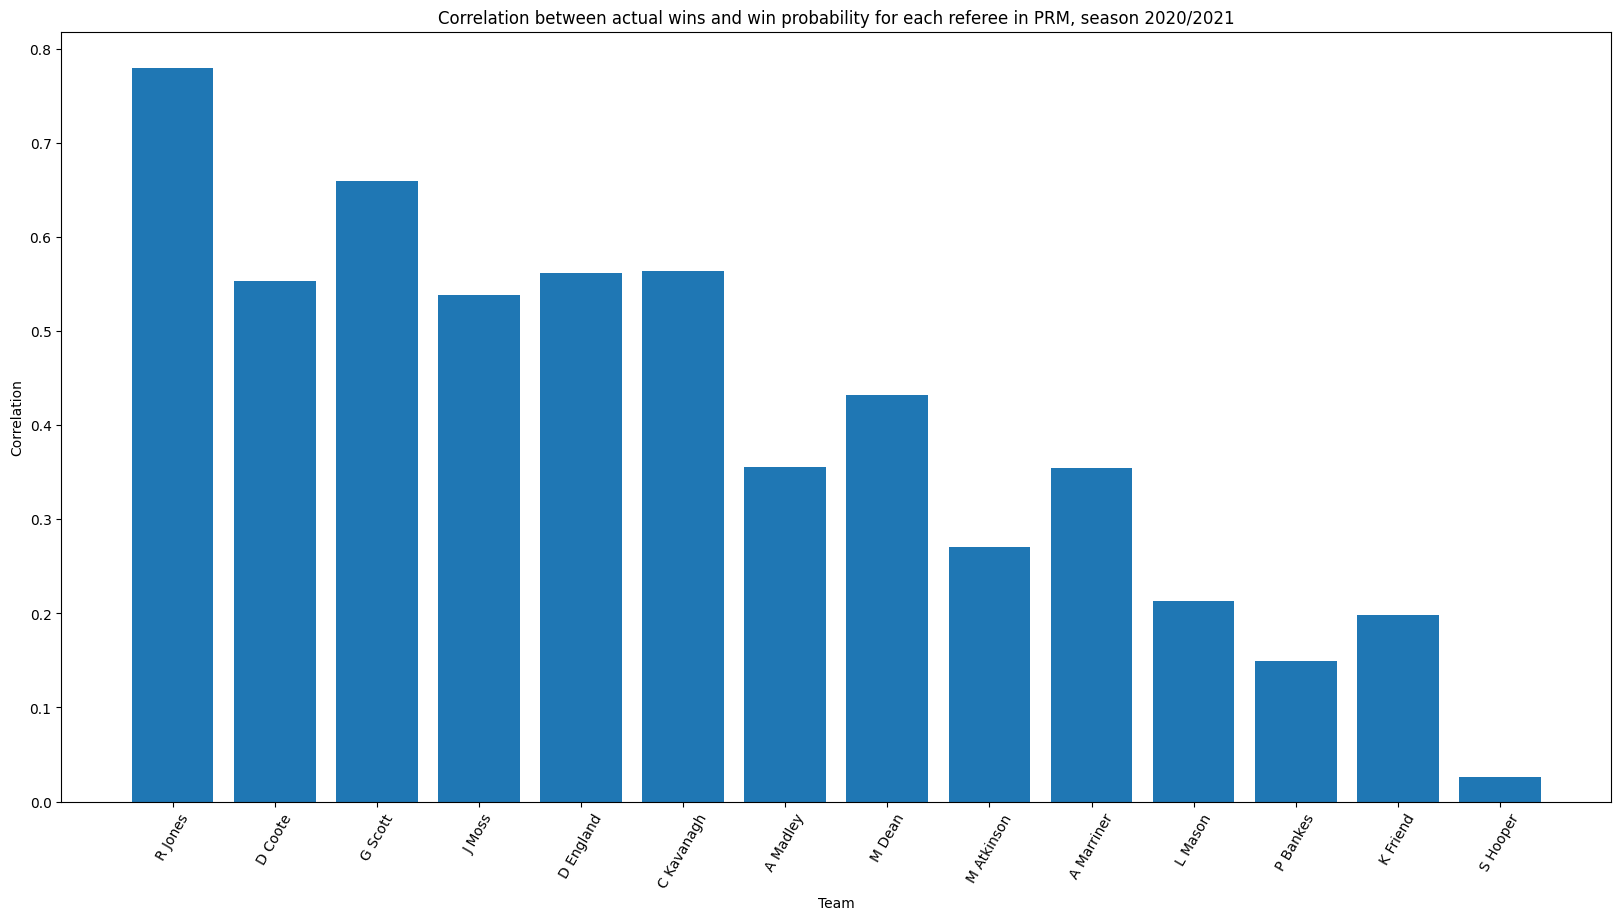

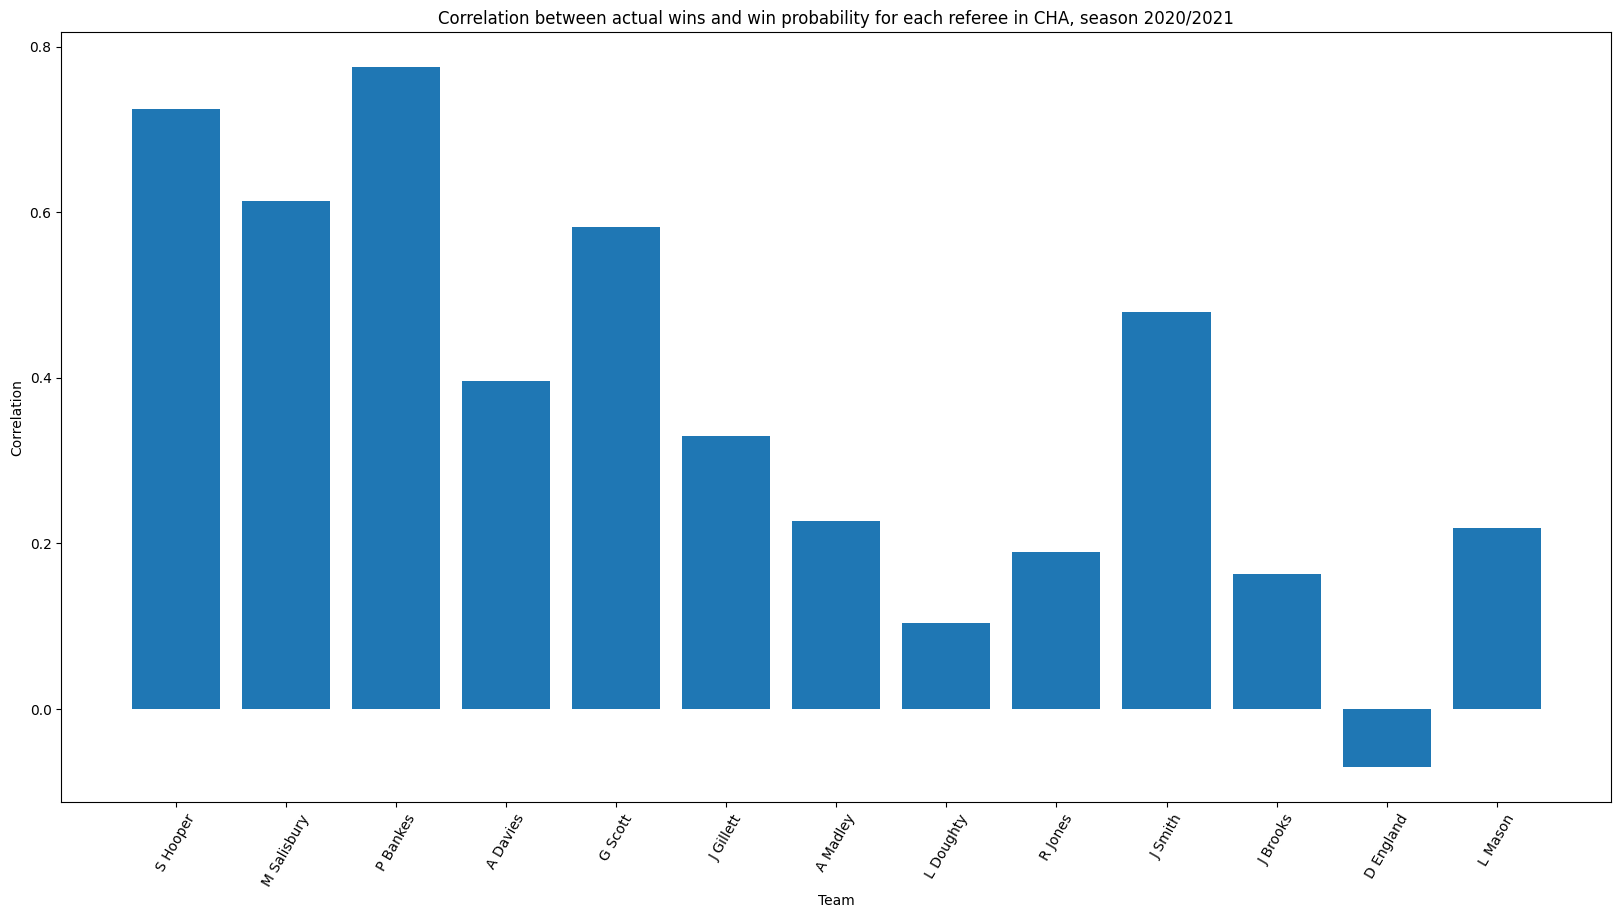

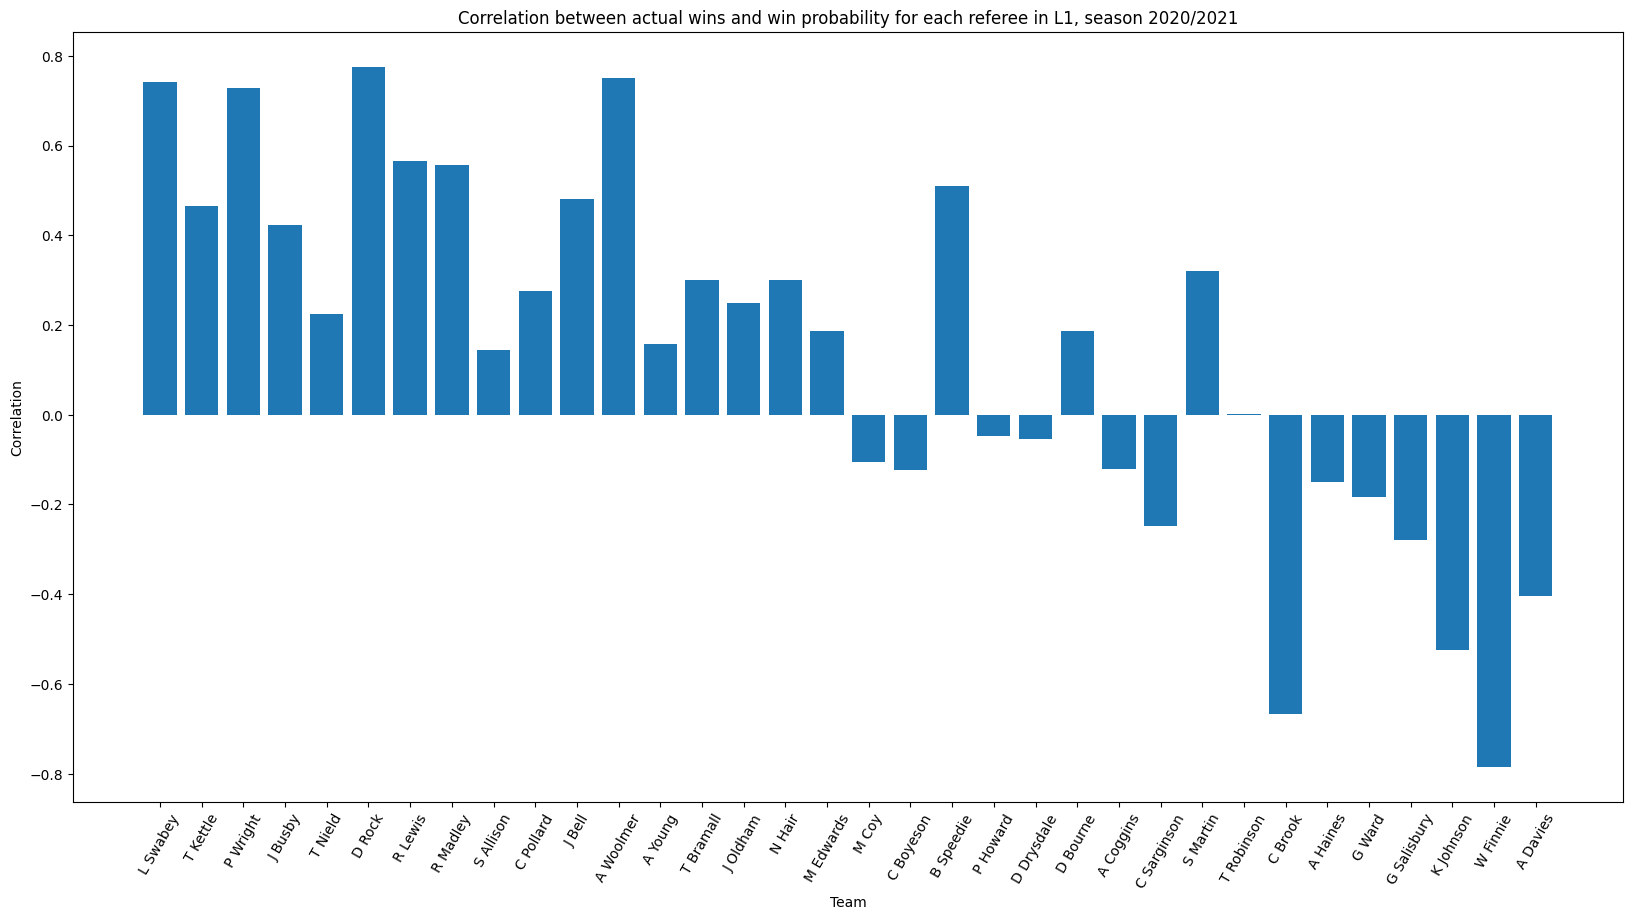

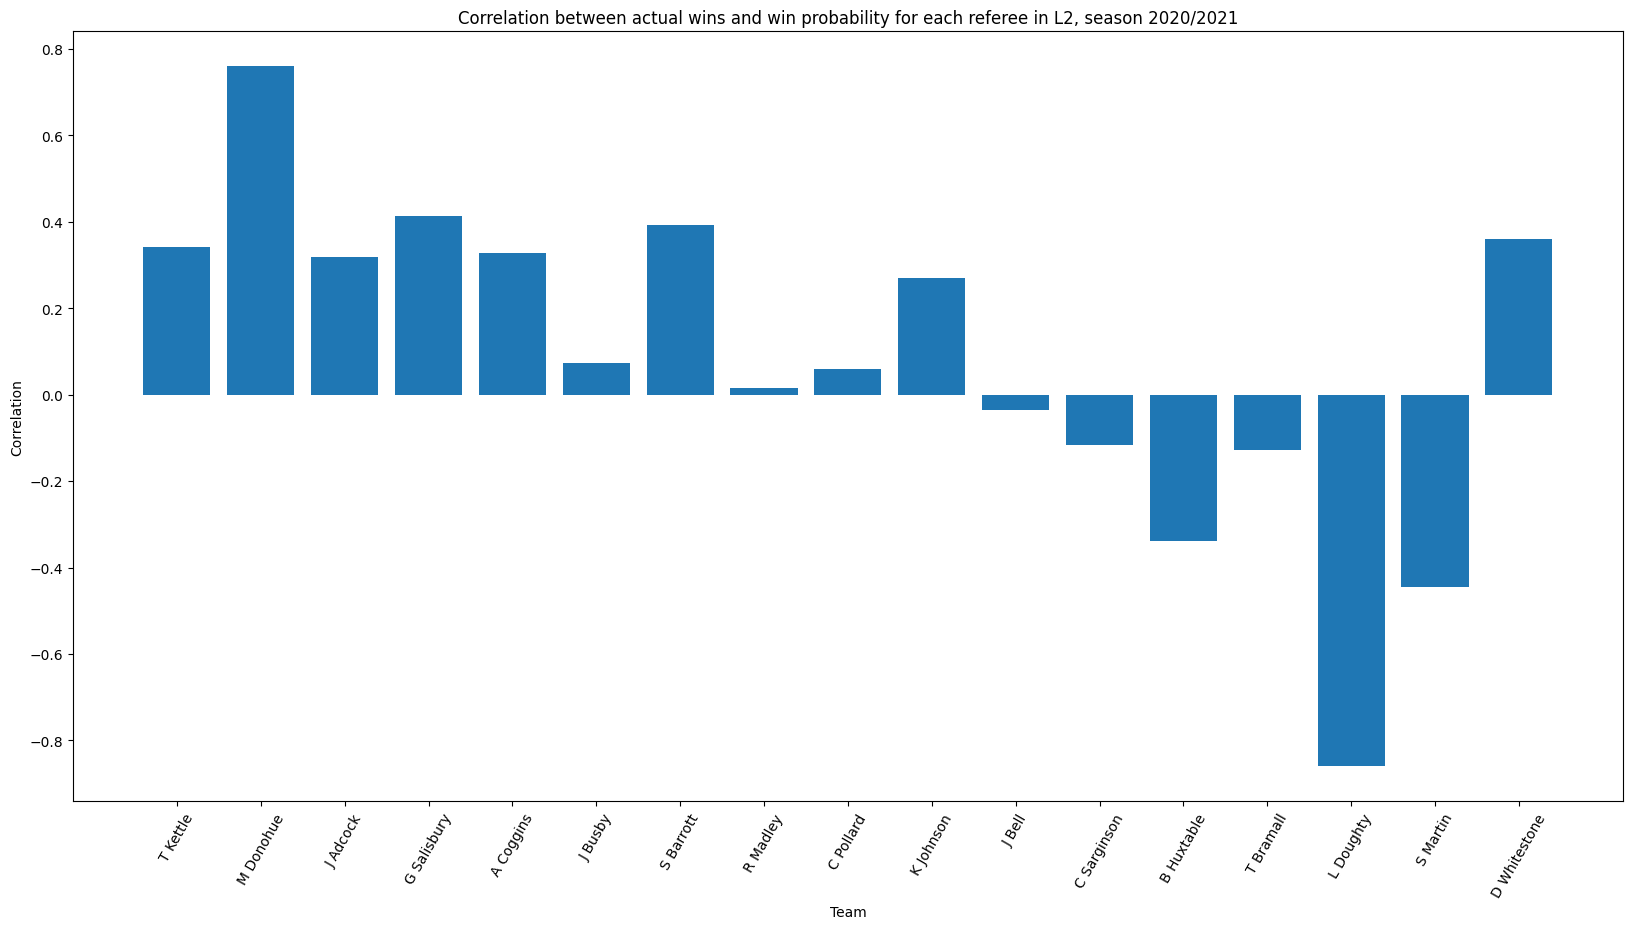

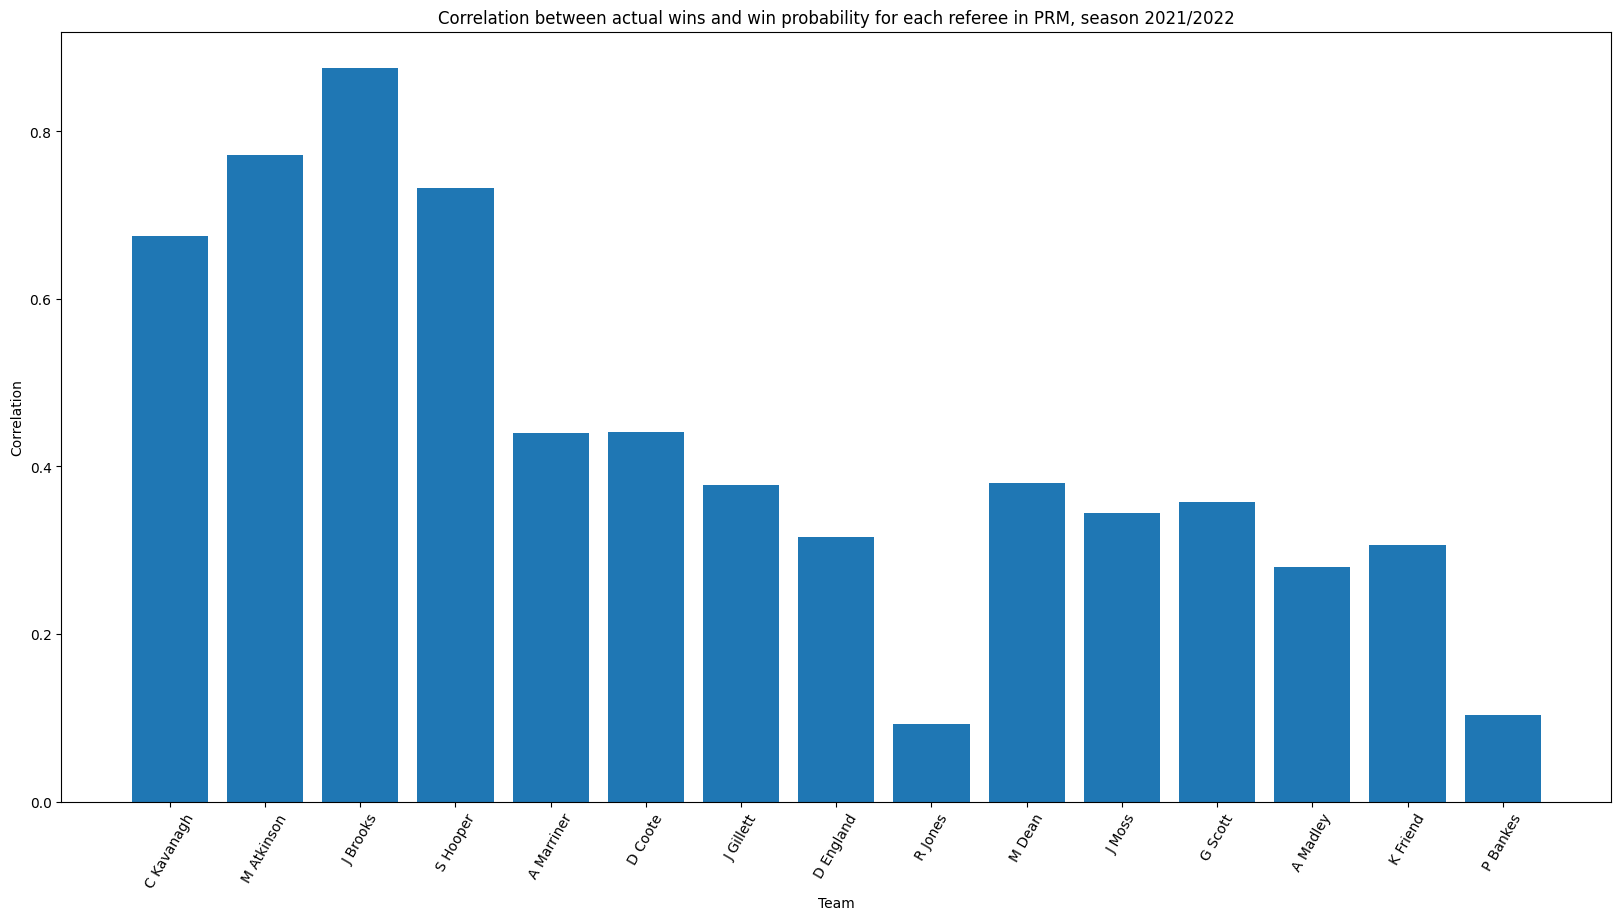

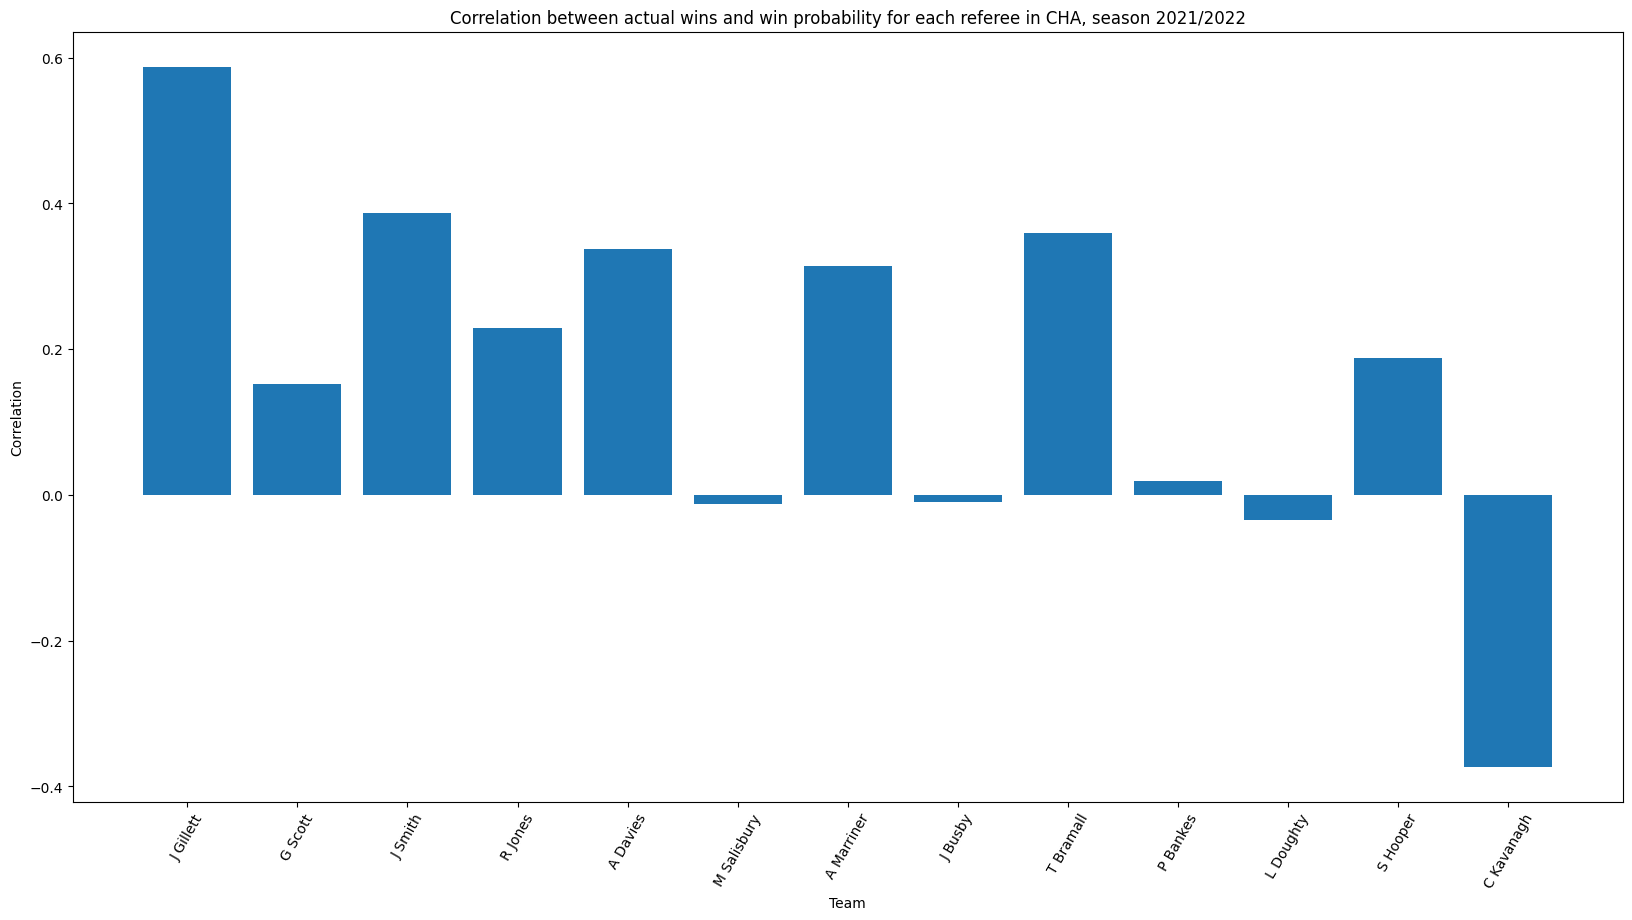

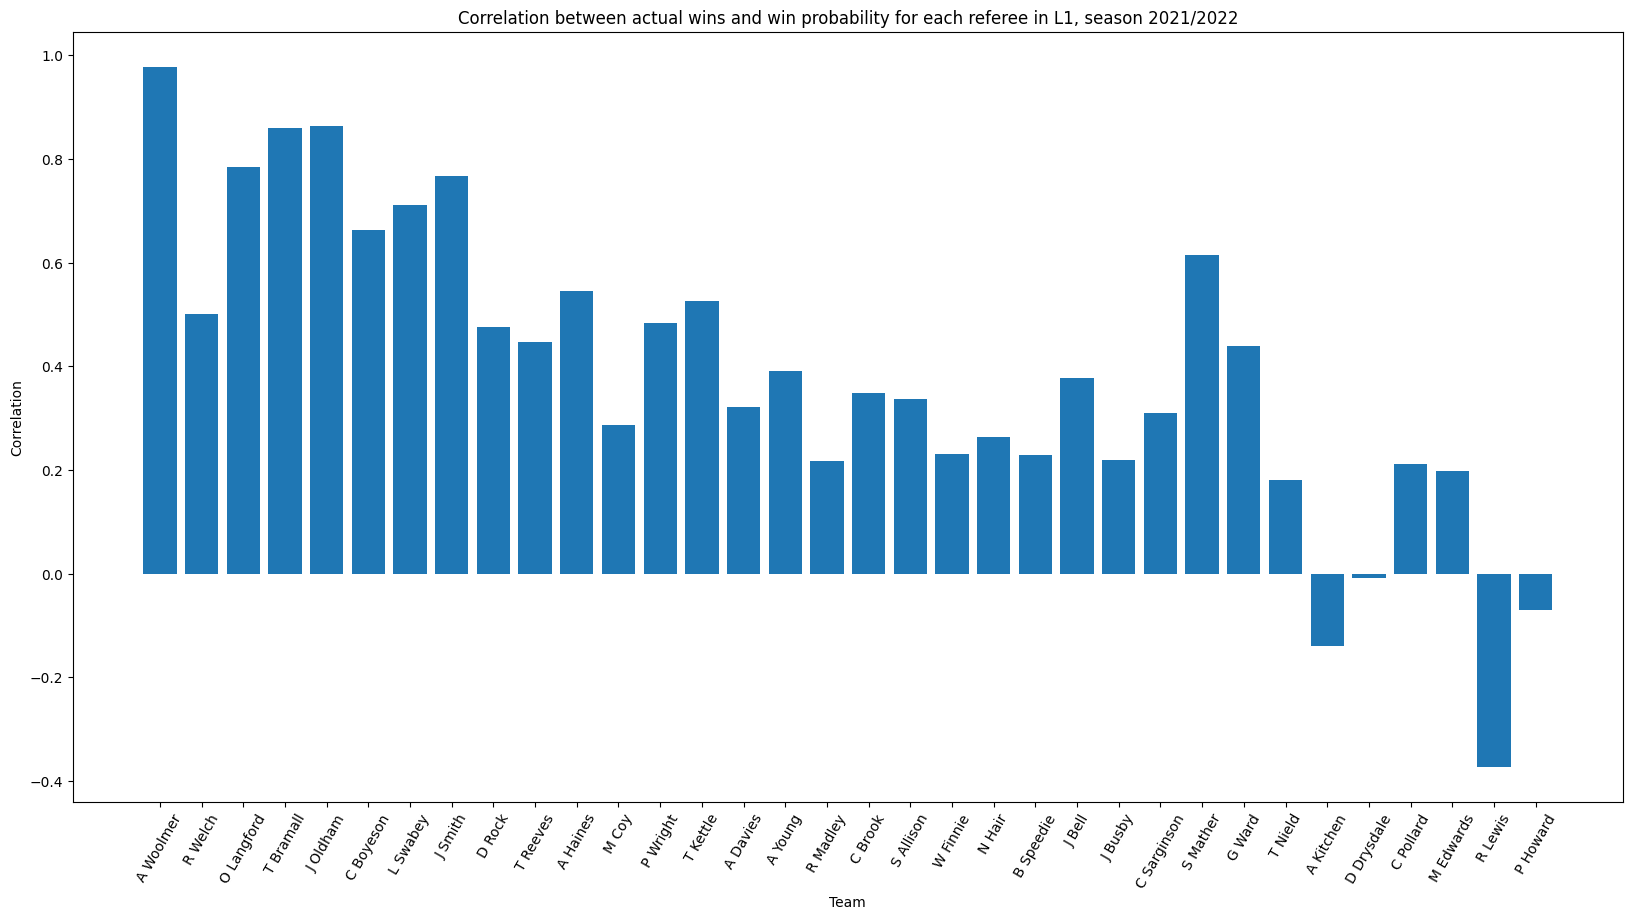

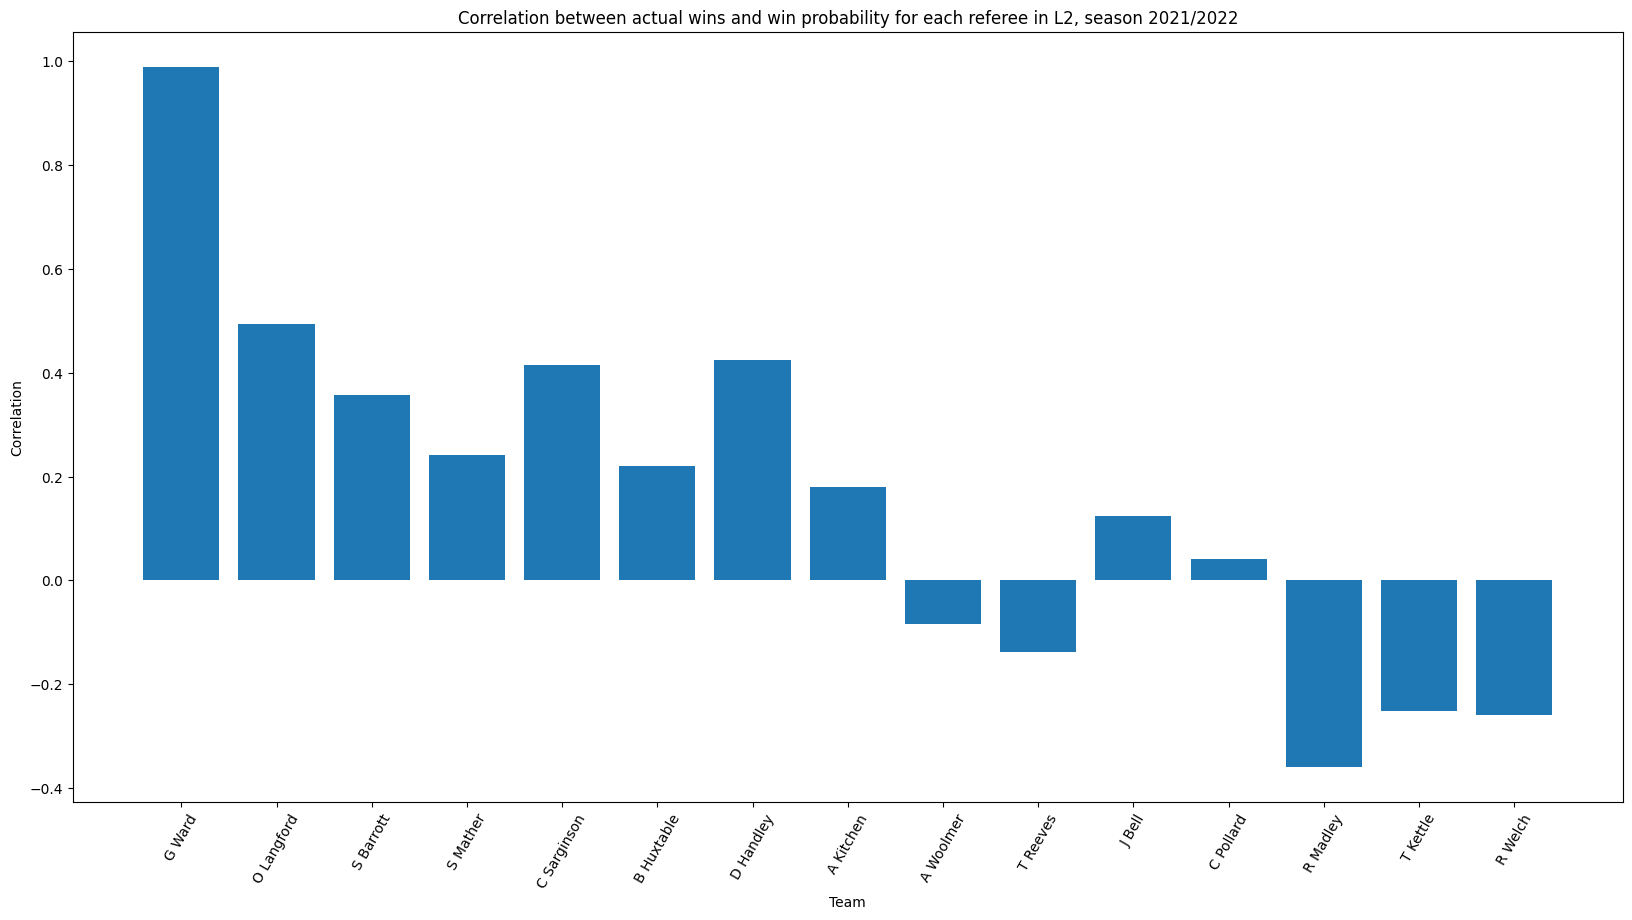

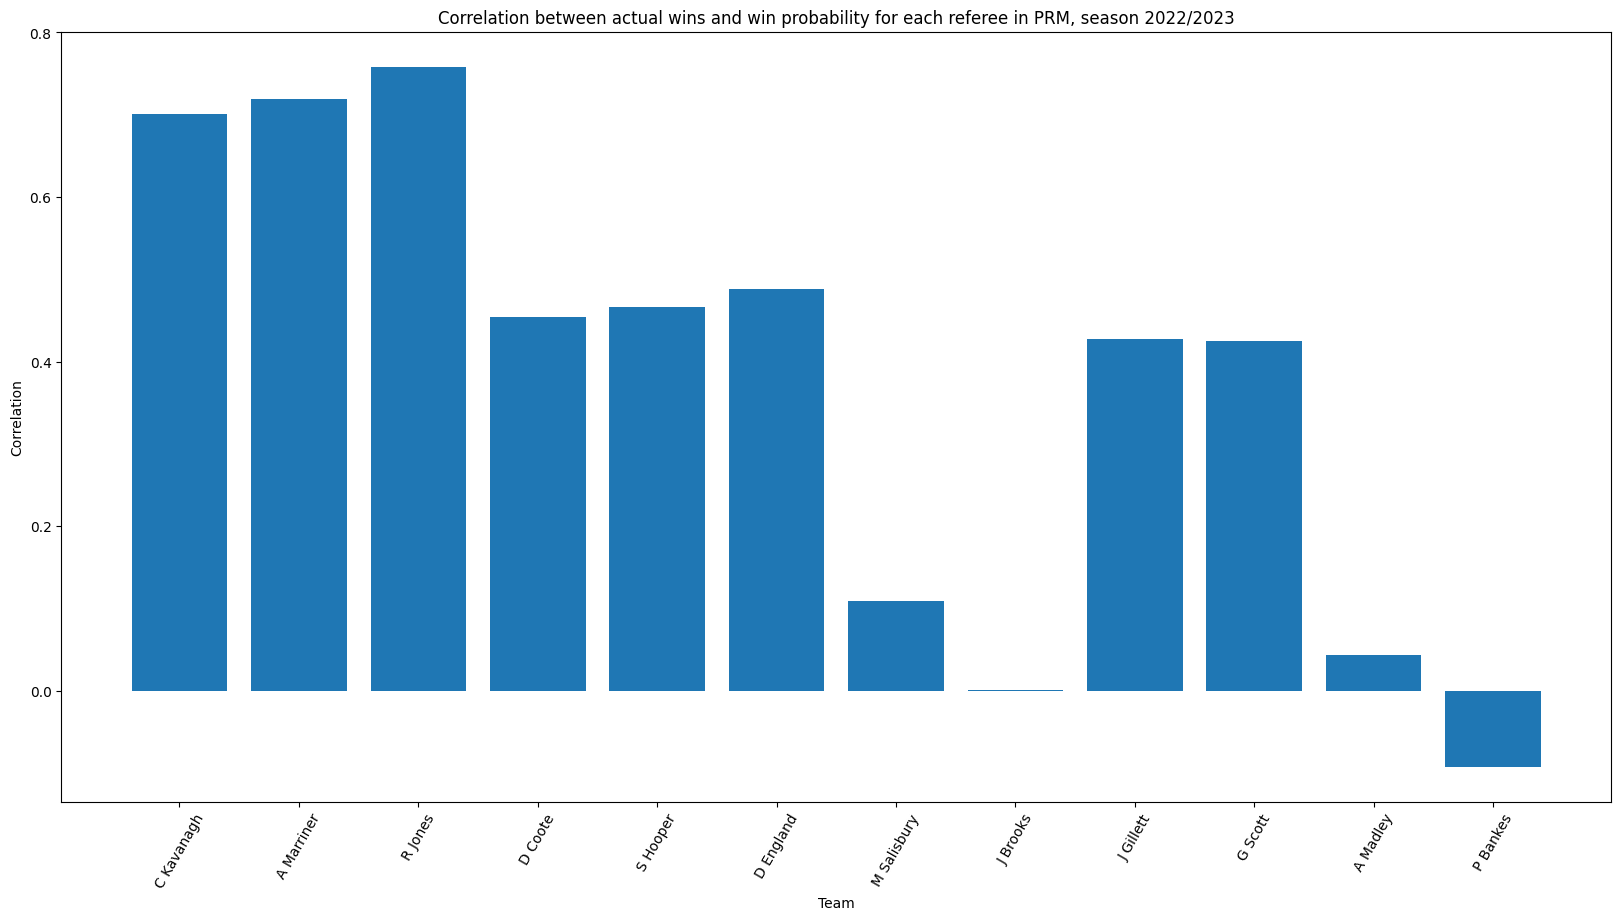

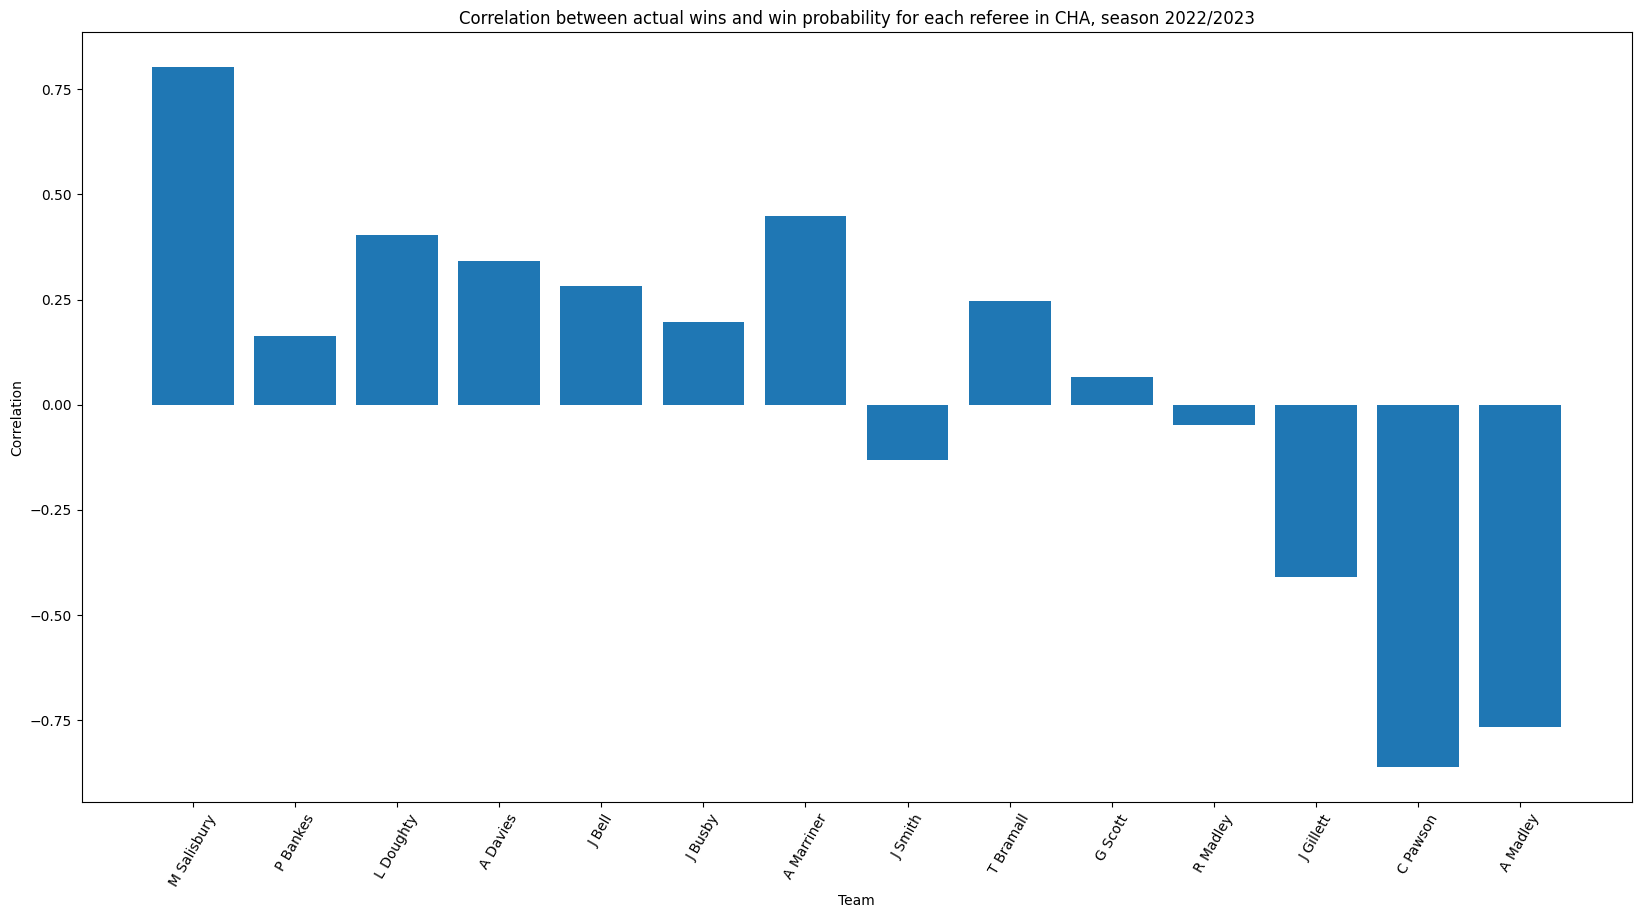

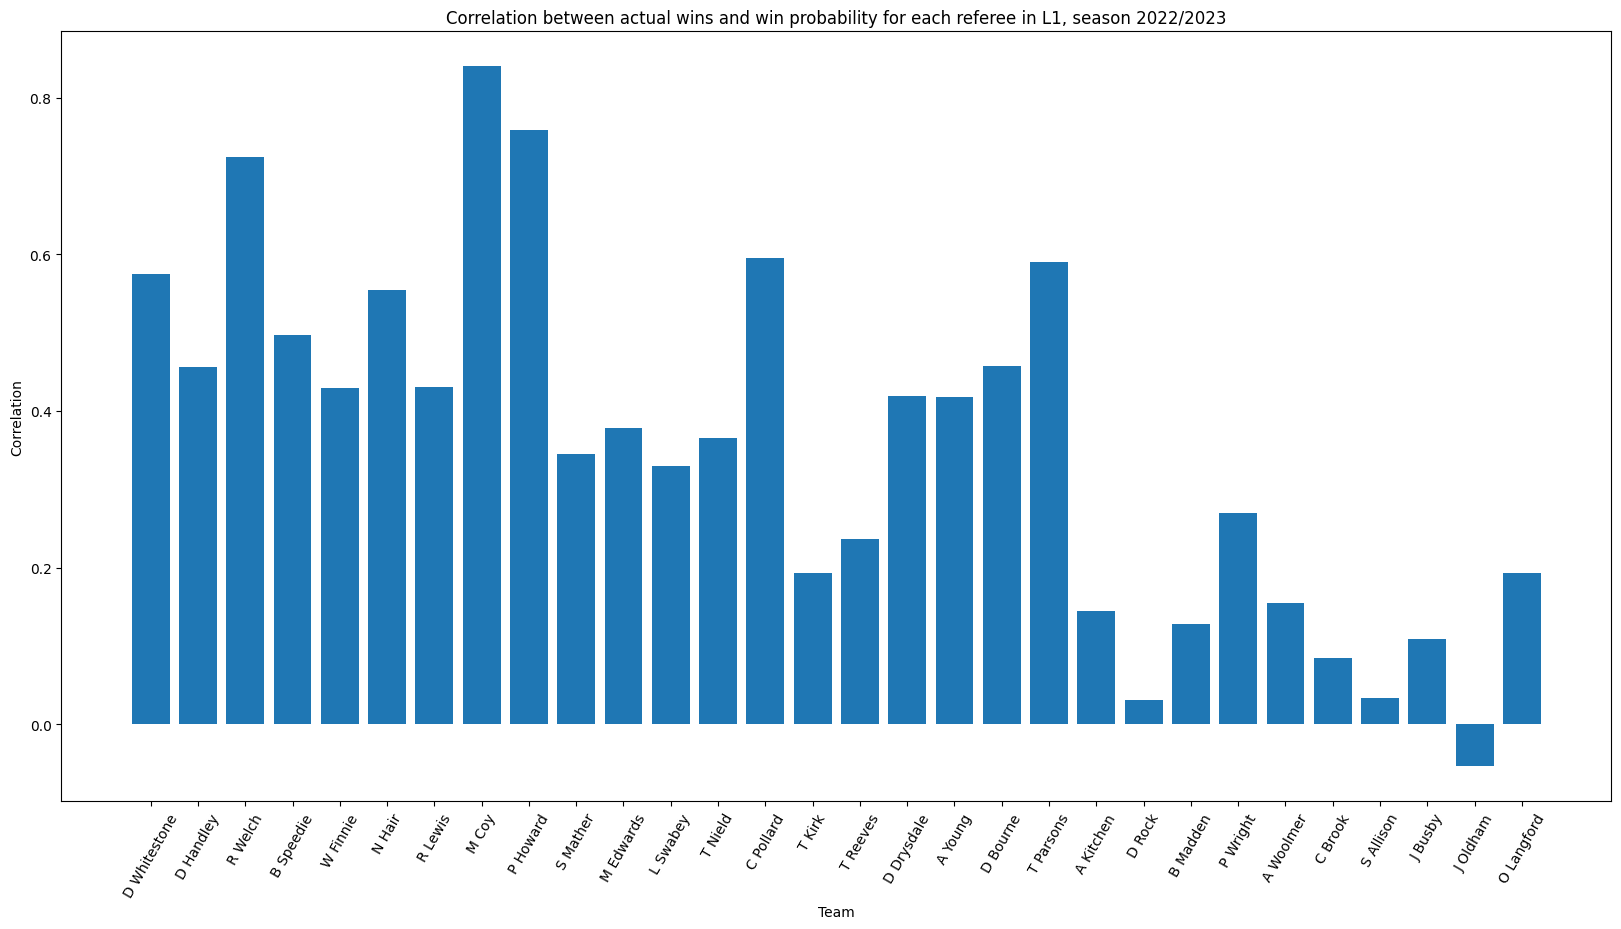

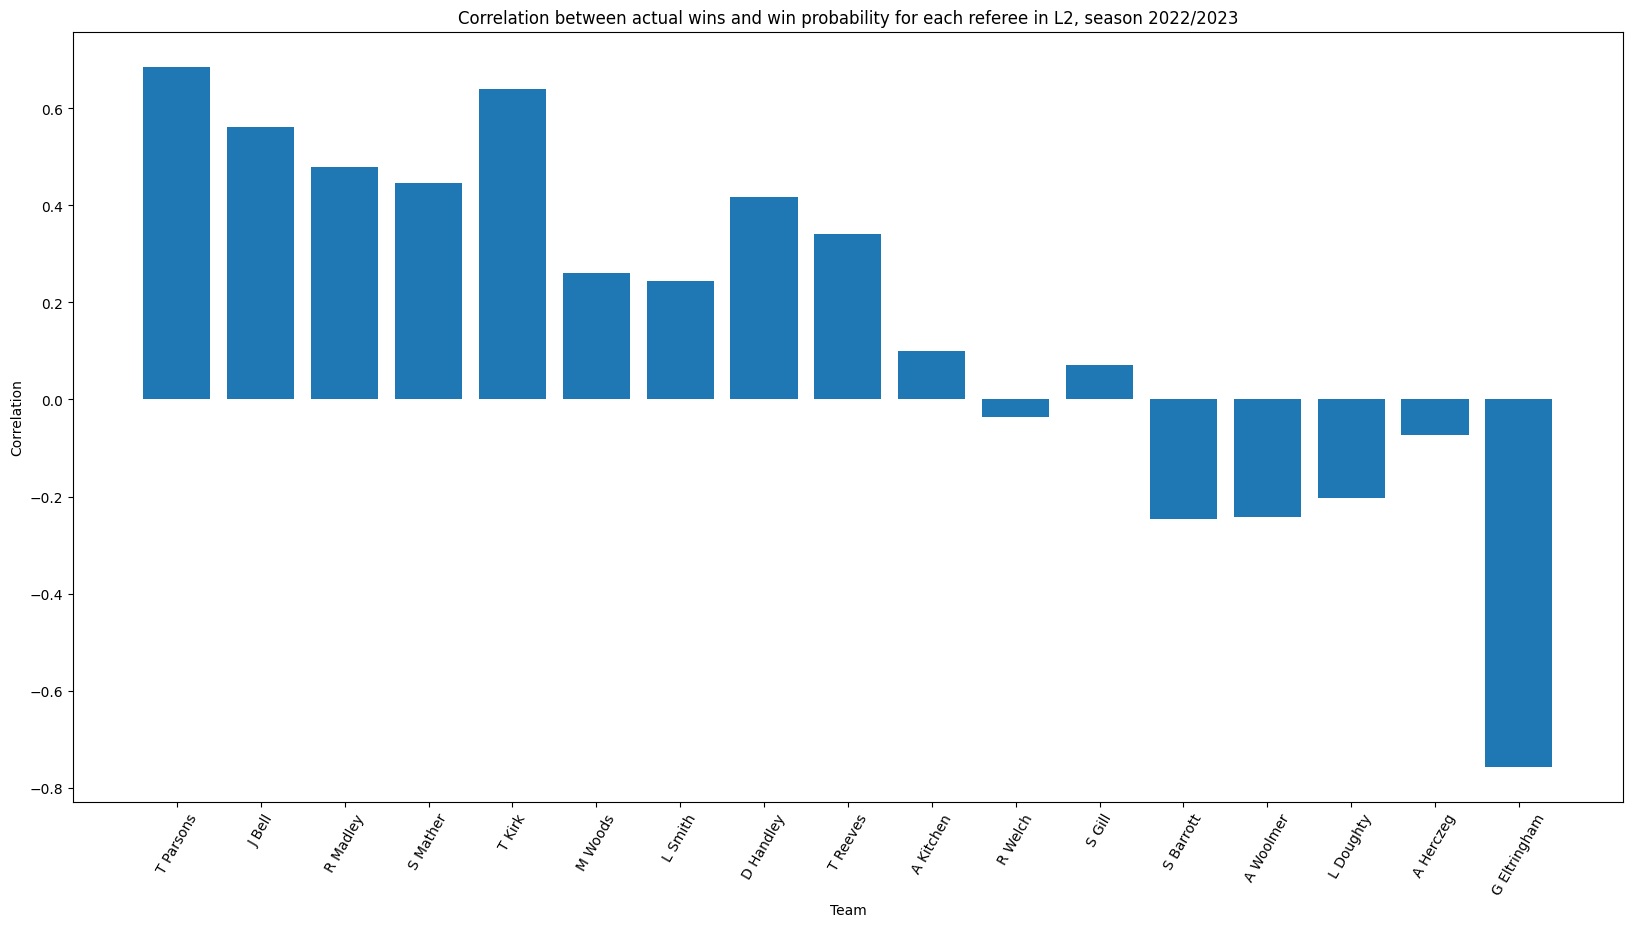

In [155]:
leagues = data['Level'].unique()
n_seasons = data['Season'].nunique()

groupedreferees = data.groupby('Referee')
referees = {name: referee for name, referee in groupedreferees}

for i, referee in enumerate(referees):
    referees[referee]['B365H_prob'] = referees[referee]['B365H'].apply(b365_odds_to_probability)
    referees[referee]['B365D_prob'] = referees[referee]['B365D'].apply(b365_odds_to_probability)
    referees[referee]['B365A_prob'] = referees[referee]['B365A'].apply(b365_odds_to_probability)

seasonal_data = {}

for i, season in enumerate(data['Season'].unique()):
    league_referees_corr = {}

    for j, league in enumerate(leagues):
        league_referees_corr[league] = pd.DataFrame(index=referees.keys(), columns=['matches', 'home_corr', 'draw_corr', 'away_corr', 'mean_corr'])

    # calculate correlation between actual wins and win  where referees are indexes and columns are home_corr, draw_corr and away_corr
    for league in leagues:
        for i, referee in enumerate(referees):
            league_referees_corr[league].loc[referee, 'matches'] = len(referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)])
            league_referees_corr[league].loc[referee, 'home_corr'] = referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['B365H_prob'].corr(referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['FTR'] == 'H')
            league_referees_corr[league].loc[referee, 'draw_corr'] = referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['B365D_prob'].corr(referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['FTR'] == 'D')
            league_referees_corr[league].loc[referee, 'away_corr'] = referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['B365A_prob'].corr(referees[referee][(referees[referee]['Level'] == league) & (referees[referee]['Season'] == season)]['FTR'] == 'A')
        league_referees_corr[league]['mean_corr'] = league_referees_corr[league][['home_corr', 'draw_corr', 'away_corr']].mean(axis=1)
        league_referees_corr[league].sort_values(by='mean_corr', inplace=True, ascending=False)
    for league in leagues:
        league_referees_corr[league].dropna(inplace=True)
        league_referees_corr[league].to_csv('referees_corr_{}.csv'.format(league))

    PRM_referees = league_referees_corr['PRM'].index
    for league in leagues:
        #league_referees_corr[league] = league_referees_corr[league].loc[league_referees_corr[league].index.intersection(PRM_referees)]
        league_referees_corr[league].sort_values(by='mean_corr', inplace=True, ascending=False)
        league_referees_corr[league].to_csv('./league_per_season/referees_corr_{}_{}.csv'.format(league, season.replace('/', '-')))
    seasonal_data[season] = league_referees_corr

#plot correlation between actual wins and win probability for each team
for i, season in enumerate(data['Season'].unique()):
    for league in leagues:
        plt.figure(figsize=(20, 10))
        plt.title('Correlation between actual wins and win probability for each referee in {}, season {}'.format(league, season))
        plt.xlabel('Team')
        plt.ylabel('Correlation')
        plt.bar(seasonal_data[season][league].index, seasonal_data[season][league]['home_corr'])
        plt.xticks(rotation=60)
        plt.savefig('./images/per_team_referee/referee_corr_{}_{}.png'.format(season.replace('/', '-'), league))

referees_desc = {}
for season in seasonal_data:
    referees_desc[season] = {}
    for league in seasonal_data[season]:
        referees_desc[season][league] = {"max": seasonal_data[season][league]['mean_corr'].max(), "mean": seasonal_data[season][league]['mean_corr'].mean(), "min": seasonal_data[season][league]['mean_corr'].min()}

# calculating data for teams per season

In [156]:
leagues = data['Level'].unique()
n_seasons = data['Season'].nunique()

groupedteams = data.groupby('HomeTeam')
teams = {name: team for name, team in groupedteams}

for i, team in enumerate(teams):
    teams[team]['B365H_prob'] = teams[team]['B365H'].apply(b365_odds_to_probability)
    teams[team]['B365D_prob'] = teams[team]['B365D'].apply(b365_odds_to_probability)
    teams[team]['B365A_prob'] = teams[team]['B365A'].apply(b365_odds_to_probability)

seasonal_data = {}

for i, season in enumerate(data['Season'].unique()):
    league_teams_corr = {}

    for j, league in enumerate(leagues):
        league_teams_corr[league] = pd.DataFrame(index=teams.keys(), columns=['matches', 'home_corr'])

    # calculate correlation between actual wins and win  where teams are indexes and columns are home_corr, draw_corr and away_corr
    for league in leagues:
        for i, team in enumerate(teams):
            league_teams_corr[league].loc[team, 'matches'] = len(teams[team][(teams[team]['Level'] == league) & (teams[team]['Season'] == season)])
            league_teams_corr[league].loc[team, 'home_corr'] = teams[team][(teams[team]['Level'] == league) & (teams[team]['Season'] == season)]['B365H_prob'].corr(teams[team][(teams[team]['Level'] == league) & (teams[team]['Season'] == season)]['FTR'] == 'H')
        league_teams_corr[league].sort_values(by='home_corr', inplace=True, ascending=False)
    for league in leagues:
        league_teams_corr[league].dropna(inplace=True)
        league_teams_corr[league].to_csv('teams_corr_{}.csv'.format(league))

    PRM_teams = league_teams_corr['PRM'].index
    for league in leagues:
        league_teams_corr[league].sort_values(by='home_corr', inplace=True, ascending=False)
        league_teams_corr[league].to_csv('./league_per_season/teams_corr_{}_{}.csv'.format(league, season.replace('/', '-')))
    seasonal_data[season] = league_teams_corr

#plot correlation between actual wins and win probability for each team
for i, season in enumerate(data['Season'].unique()):
    for league in leagues:
        plt.figure(figsize=(20, 10))
        plt.title('Correlation between actual wins and win probability for each team in {}, season {}'.format(league, season))
        plt.xlabel('Team')
        plt.ylabel('Correlation')
        plt.bar(seasonal_data[season][league].index, seasonal_data[season][league]['home_corr'])
        plt.xticks(rotation=60)
        plt.savefig('./images/per_team_referee/teams_corr_{}_{}.png'.format(season.replace('/', '-'), league))

teams_desc = {}
for season in seasonal_data:
    teams_desc[season] = {}
    for league in seasonal_data[season]:
        teams_desc[season][league] = {"max": seasonal_data[season][league]['home_corr'].max(), "mean": seasonal_data[season][league]['home_corr'].mean(), "min": seasonal_data[season][league]['home_corr'].min()}

# visualizing descriptions of correlations per league and season

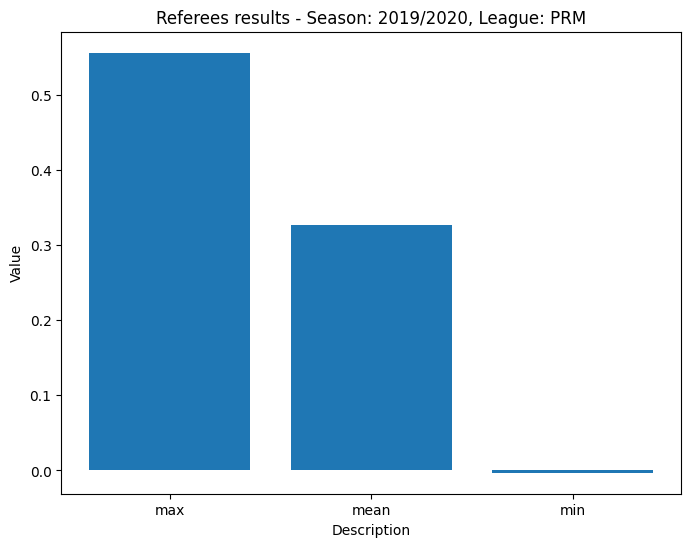

<Figure size 640x480 with 0 Axes>

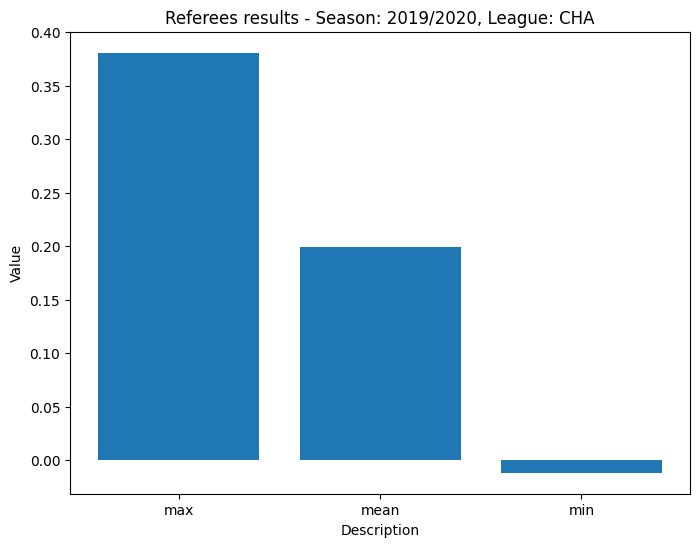

<Figure size 640x480 with 0 Axes>

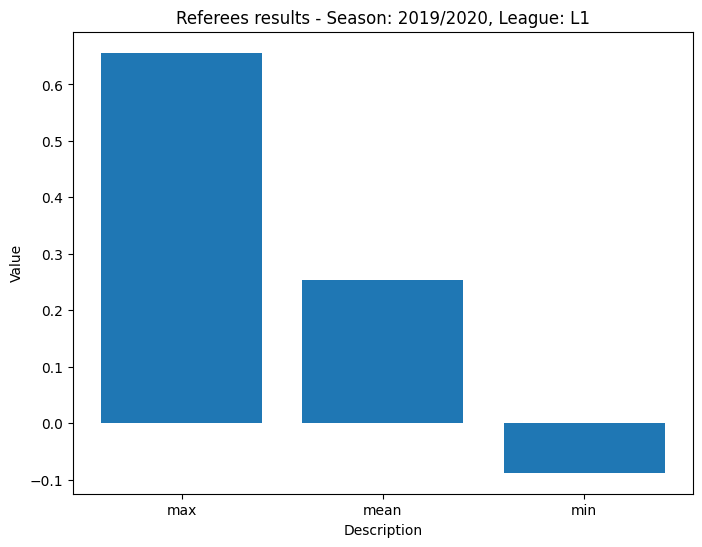

<Figure size 640x480 with 0 Axes>

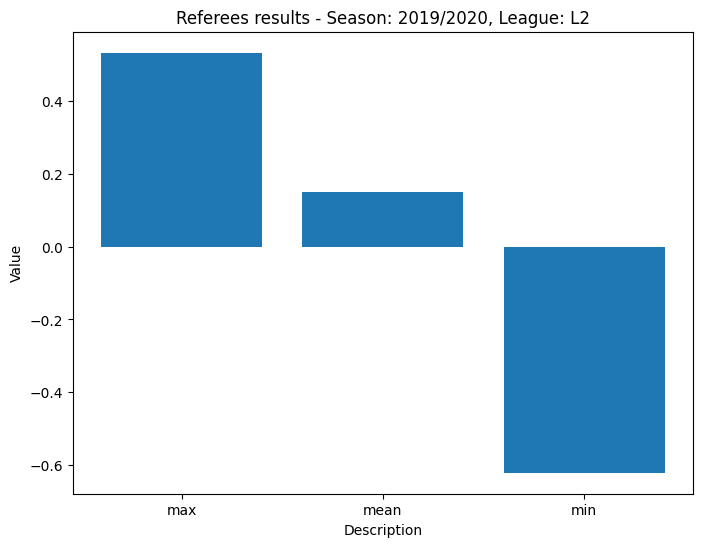

<Figure size 640x480 with 0 Axes>

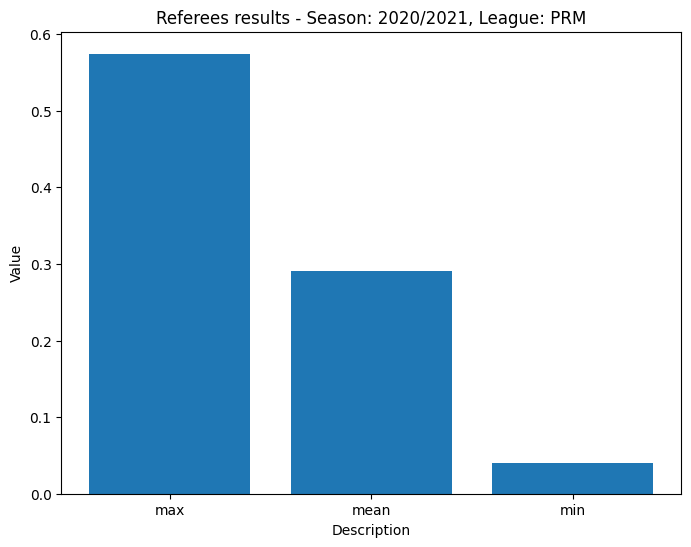

<Figure size 640x480 with 0 Axes>

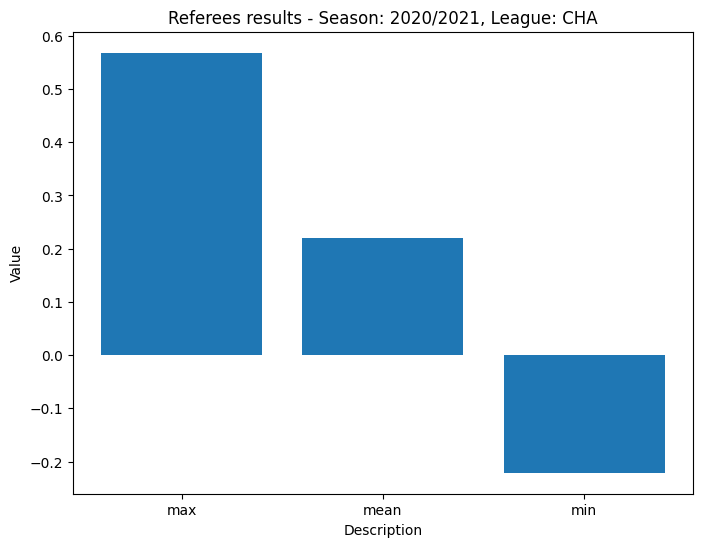

<Figure size 640x480 with 0 Axes>

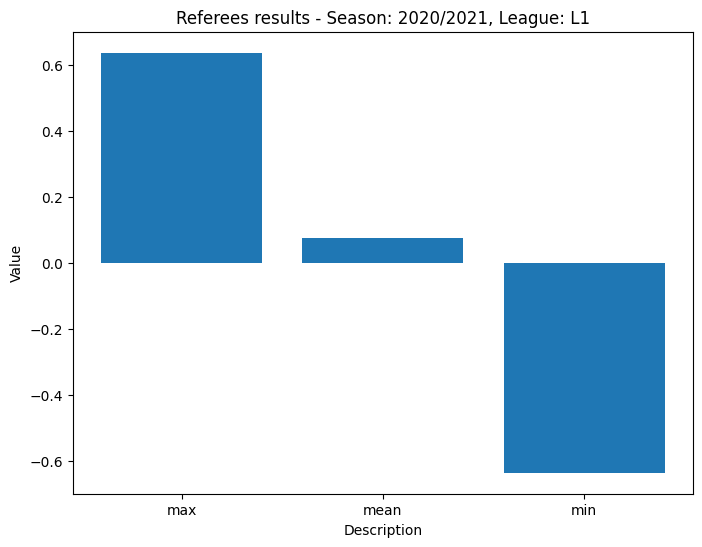

<Figure size 640x480 with 0 Axes>

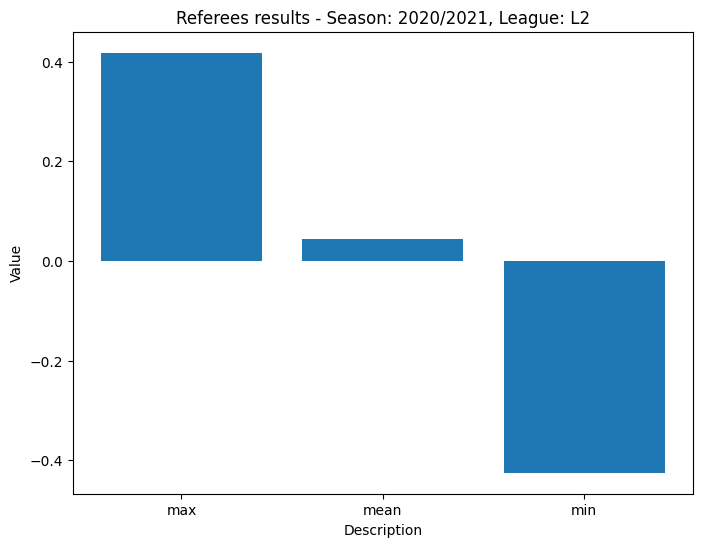

<Figure size 640x480 with 0 Axes>

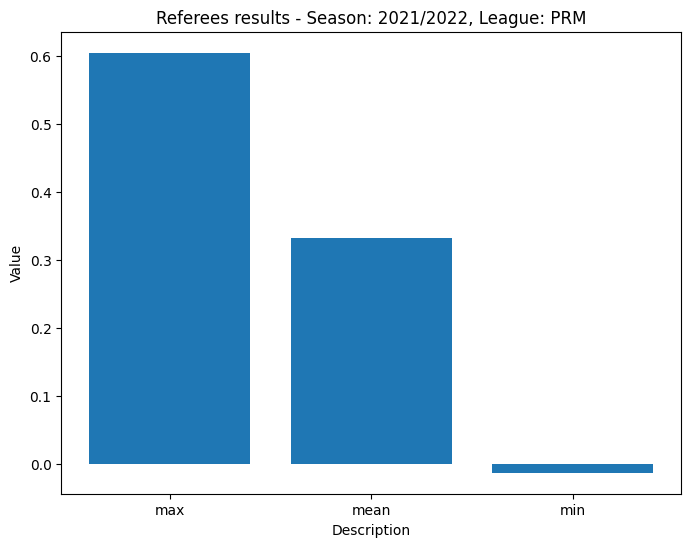

<Figure size 640x480 with 0 Axes>

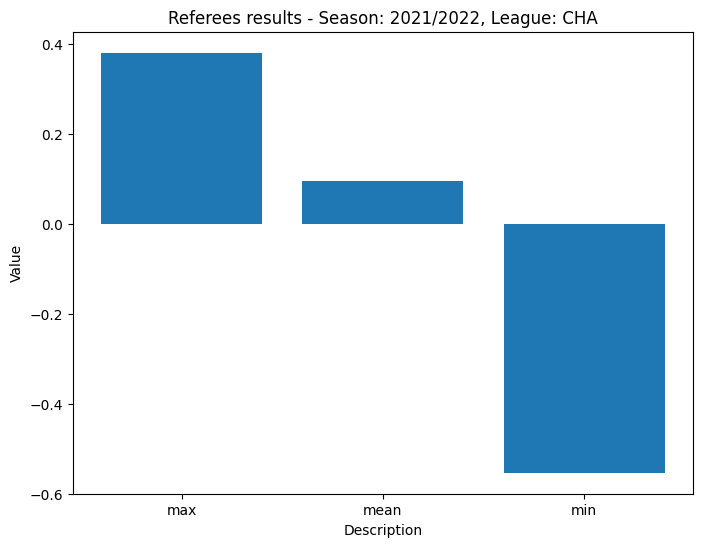

<Figure size 640x480 with 0 Axes>

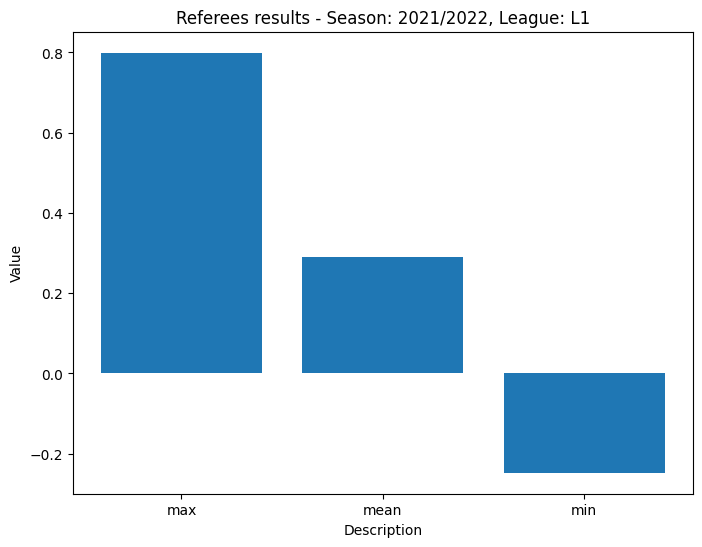

<Figure size 640x480 with 0 Axes>

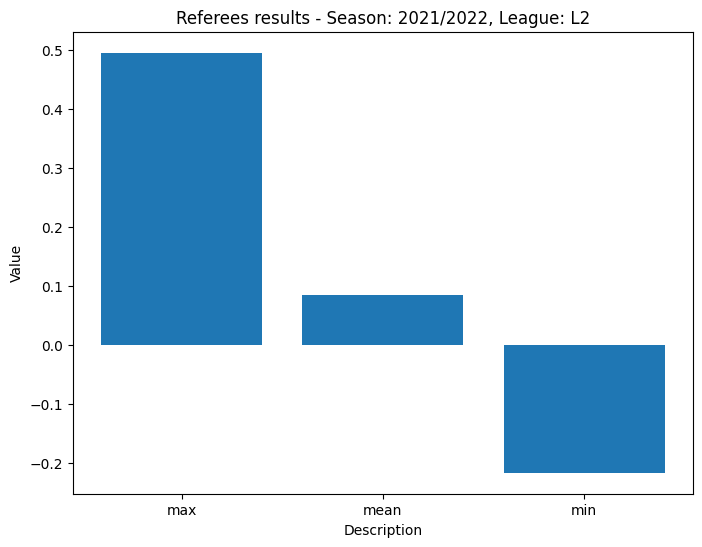

<Figure size 640x480 with 0 Axes>

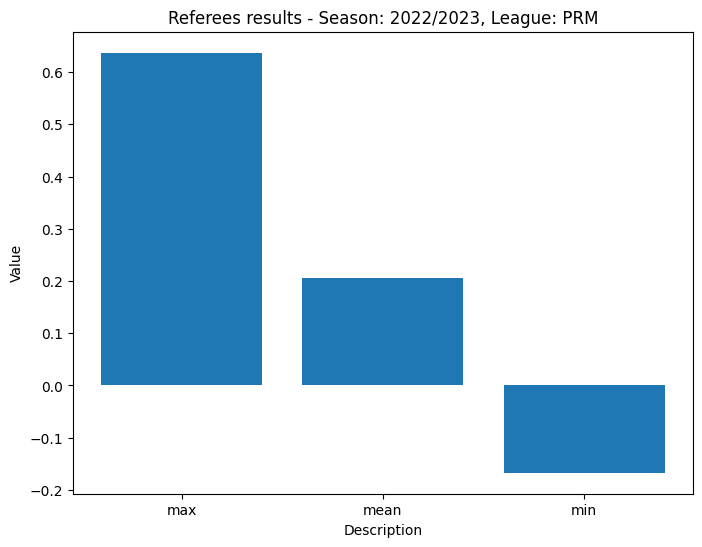

<Figure size 640x480 with 0 Axes>

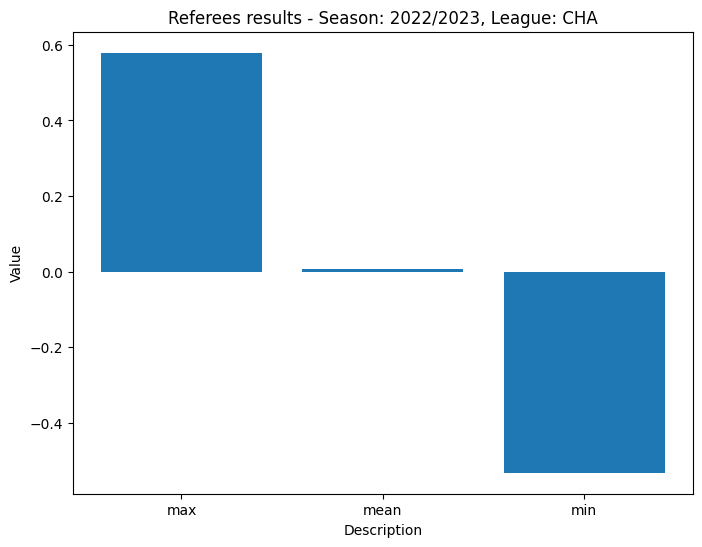

<Figure size 640x480 with 0 Axes>

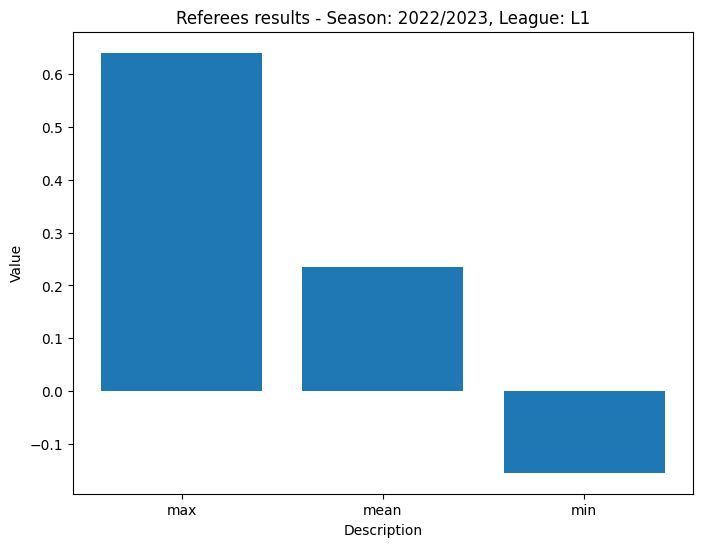

<Figure size 640x480 with 0 Axes>

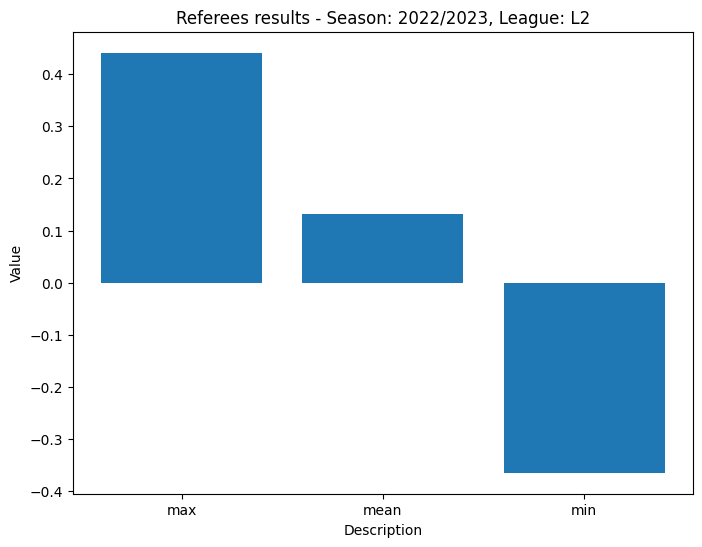

<Figure size 640x480 with 0 Axes>

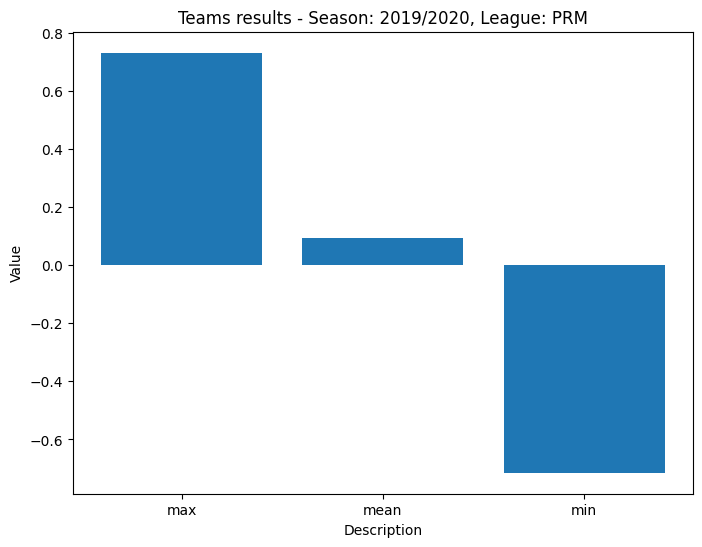

<Figure size 640x480 with 0 Axes>

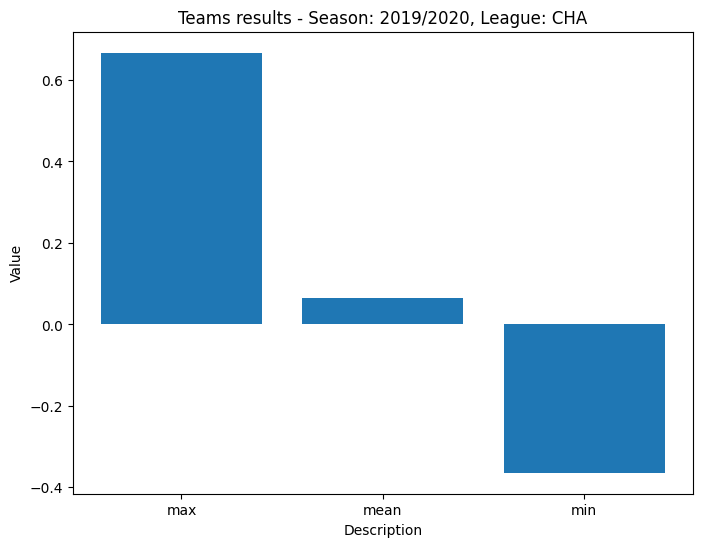

<Figure size 640x480 with 0 Axes>

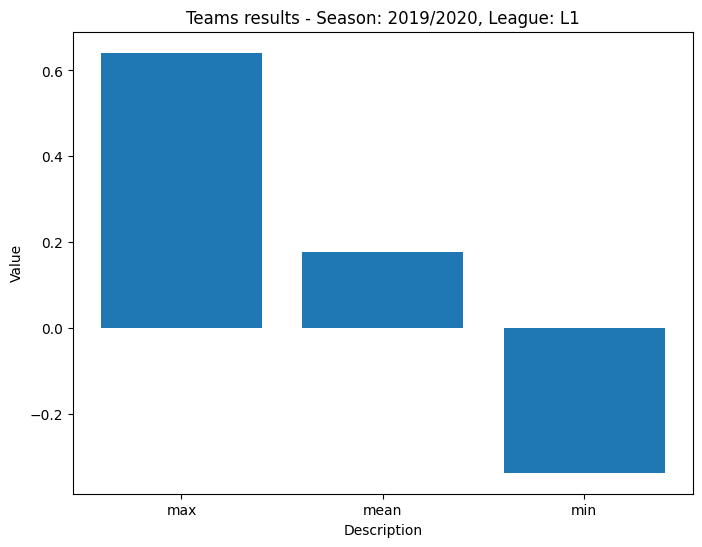

<Figure size 640x480 with 0 Axes>

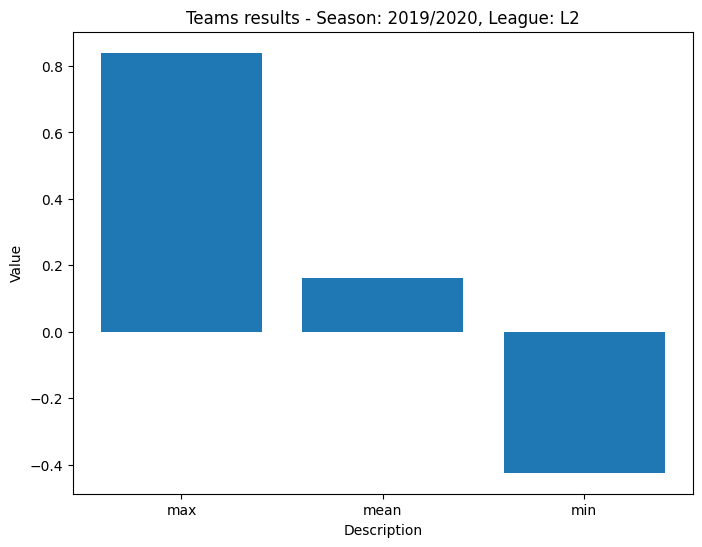

<Figure size 640x480 with 0 Axes>

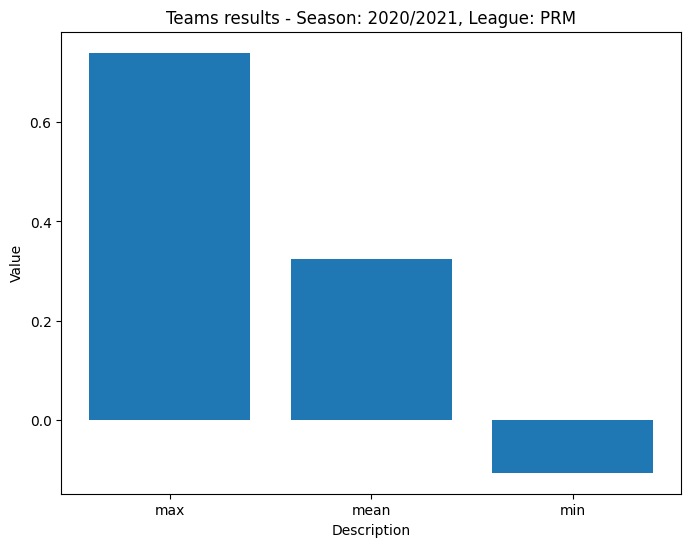

<Figure size 640x480 with 0 Axes>

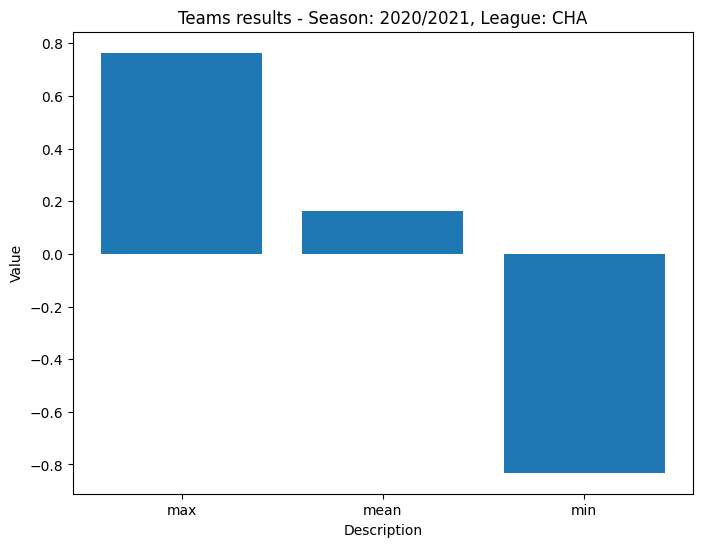

<Figure size 640x480 with 0 Axes>

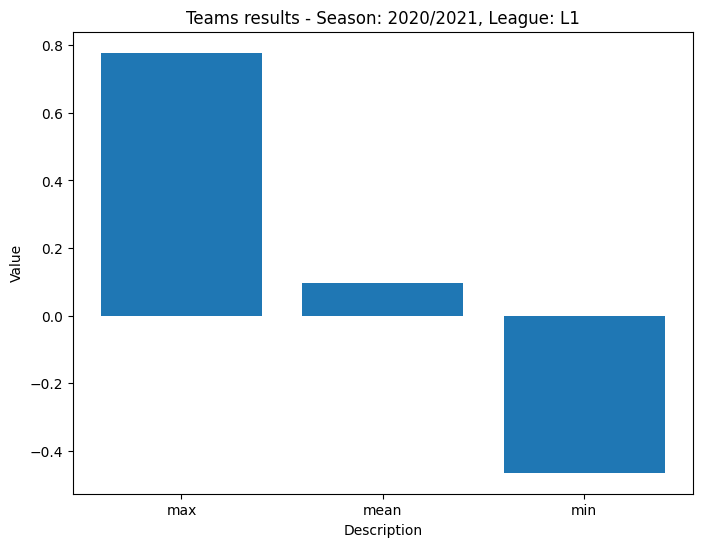

<Figure size 640x480 with 0 Axes>

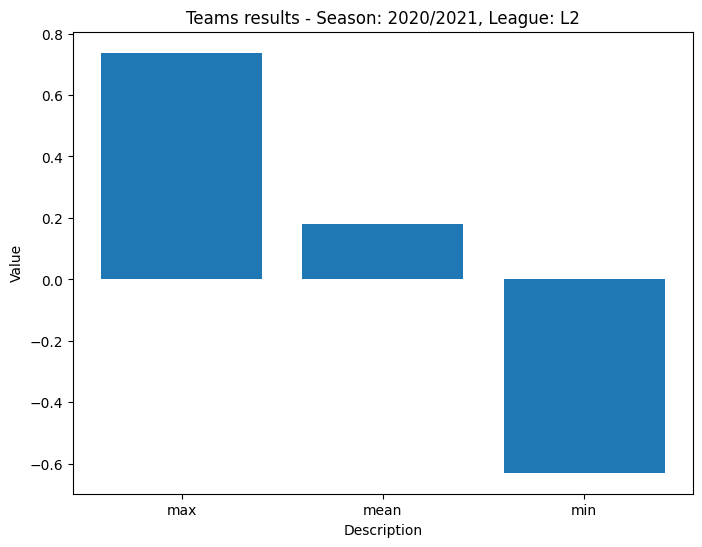

<Figure size 640x480 with 0 Axes>

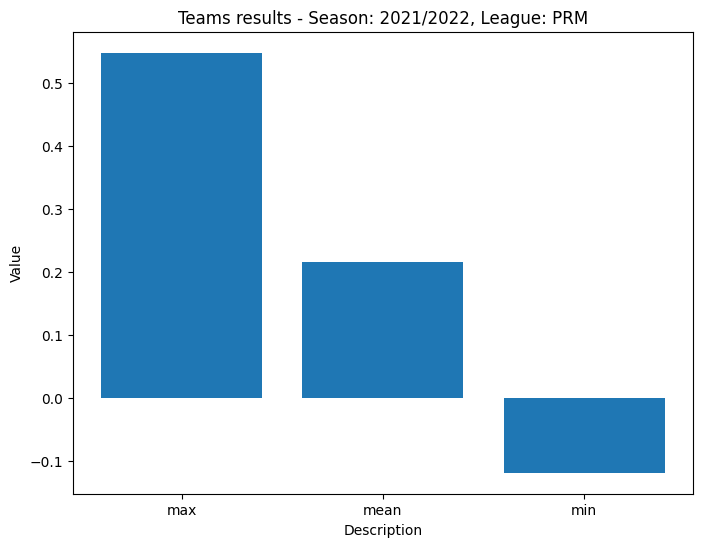

<Figure size 640x480 with 0 Axes>

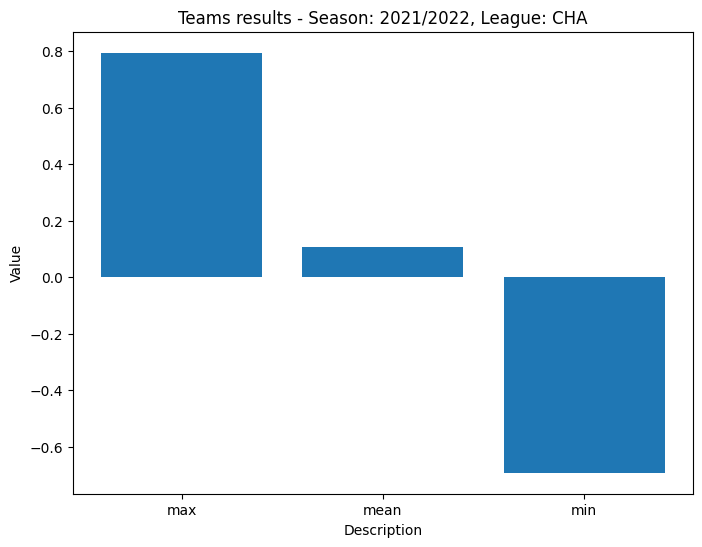

<Figure size 640x480 with 0 Axes>

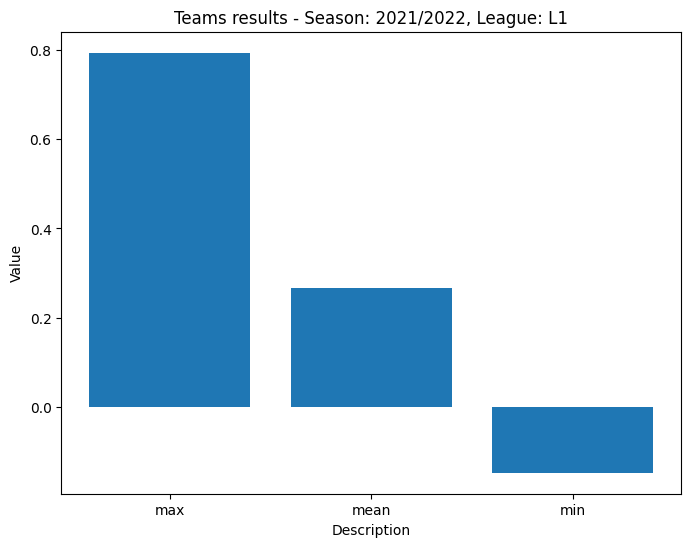

<Figure size 640x480 with 0 Axes>

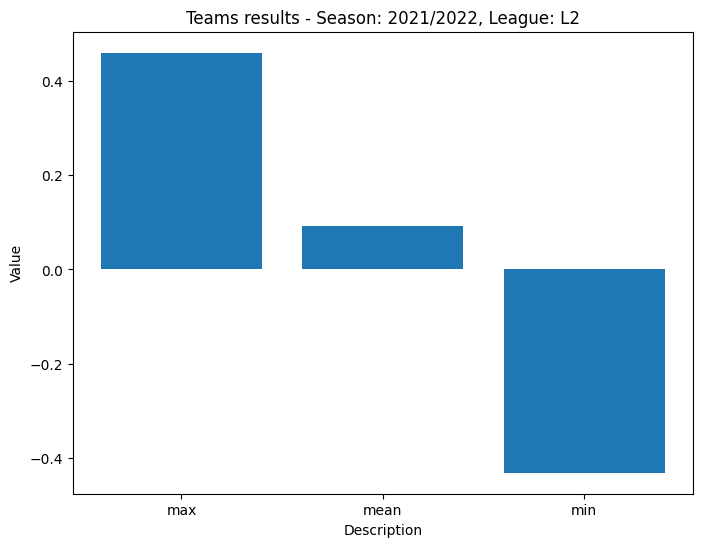

<Figure size 640x480 with 0 Axes>

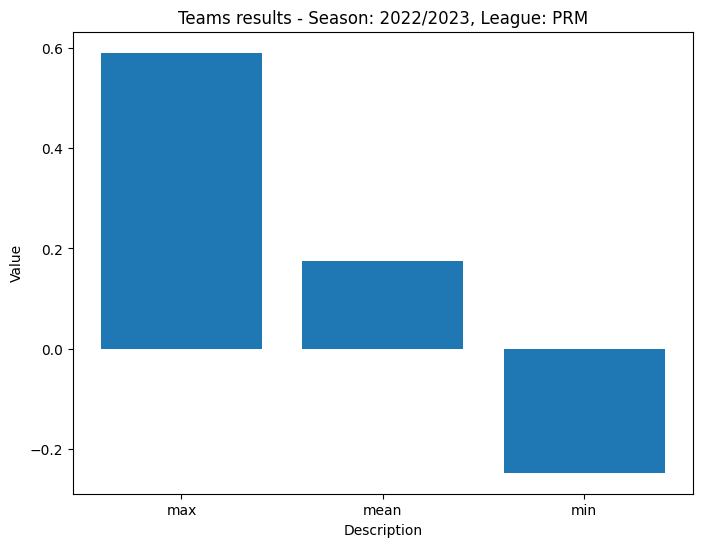

<Figure size 640x480 with 0 Axes>

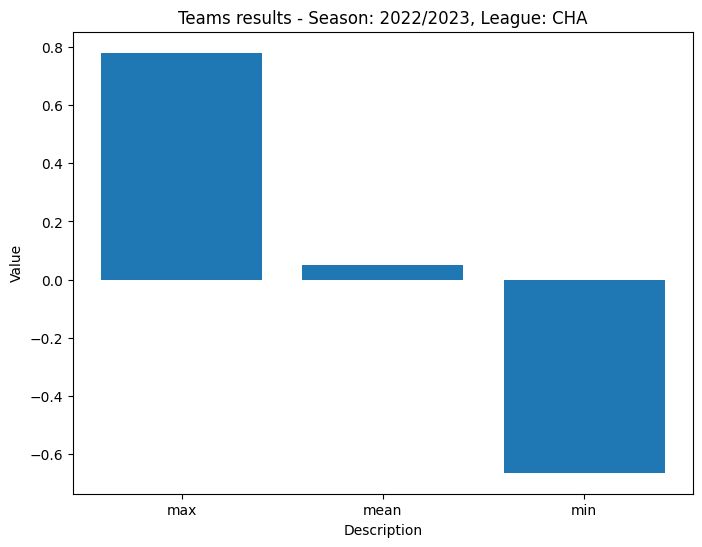

<Figure size 640x480 with 0 Axes>

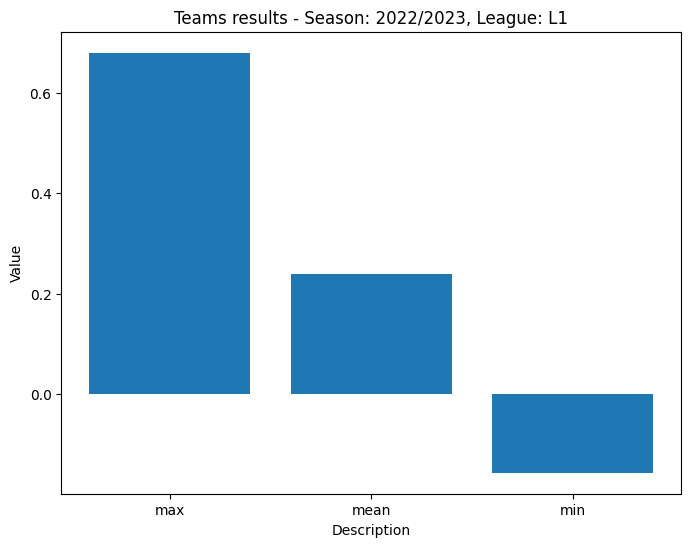

<Figure size 640x480 with 0 Axes>

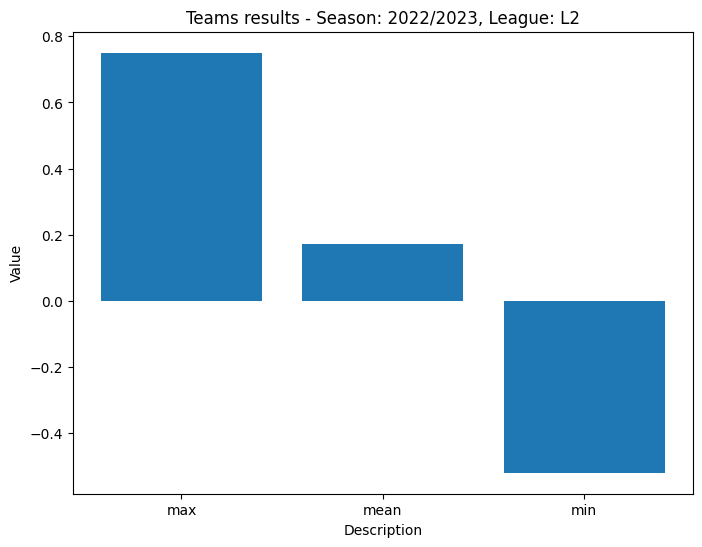

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

for season in referees_desc:
    for league in referees_desc[season]:
        plt.figure(figsize=(8, 6))
        plt.title(f"Referees results - Season: {season}, League: {league}")
        plt.xlabel("Description")
        plt.ylabel("Value")
        plt.bar(referees_desc[season][league].keys(), referees_desc[season][league].values())
        plt.show()
        plt.savefig(f"./images/results_min_max/referees_{season.replace('/', '-')}_{league}.png")

# Visualize teams_desc per season and per league
for season in teams_desc:
    for league in teams_desc[season]:
        plt.figure(figsize=(8, 6))
        plt.title(f"Teams results - Season: {season}, League: {league}")
        plt.xlabel("Description")
        plt.ylabel("Value")
        plt.bar(teams_desc[season][league].keys(), teams_desc[season][league].values())
        plt.show()
        plt.savefig(f"./images/results_min_max/teams_{season.replace('/', '-')}_{league}.png")
